<a href="https://colab.research.google.com/github/kuninethan95/Sentiment_Tracker/blob/main/NLP_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BUSINESS CASE

Sentiment analysis is critical for understanding how customers, investors, and the general public feel about a companies brand. Companies are operating in an environment where anything less than a pristine image is detrimental. I have built a dashboard that shows companies how their public sentiment is changing on an hourly basis. They can use this data to make informed decisions on how to alter their public persona.

# ROADMAP

The goal of this project is to track the sentiment of major technology companies based on global news articles. I used the newsapi to source articles from around the world and filtered out those that did not provide meaningful content. Next, I used a Kaggle financial news headlines dataset to determine the best combination of unsupervised sentiment analysis models and landed on a combination of VADER and TextBlob. Then, I used this rules based model to approach to extract sentiment from the news headlines that I sourced and confidentially assigned each article a positive, neutral, or negative score. Finally, I used a Random Forest model to determine which specific words were most impactful in driving sentiment by extracting feature importance. Last, I built a dashboard on streamlit to display my findings.

# Building NLP Sentiment Model
- Link to GitHub repo: https://github.com/kuninethan95/Sentiment_Tracker
- Linke to App: https://share.streamlit.io/kuninethan95/Sentiment_Tracker/main/Sentiment_db.py

## Getting Set Up

View Only Link: https://drive.google.com/drive/folders/1YOWHabZ4DN8TJxHHcKYWsVESNhch4Dhr?usp=sharing

Use this link to download the data and store in your Google Drive. Ensure that downloaded content is stored in the root path of your Google Drive. 
File path should be as follows:

content -> drive -> MyDrive -> Colab Notebooks 


Mount Google Drive so that Google Drive files can be accessed in Google Colab

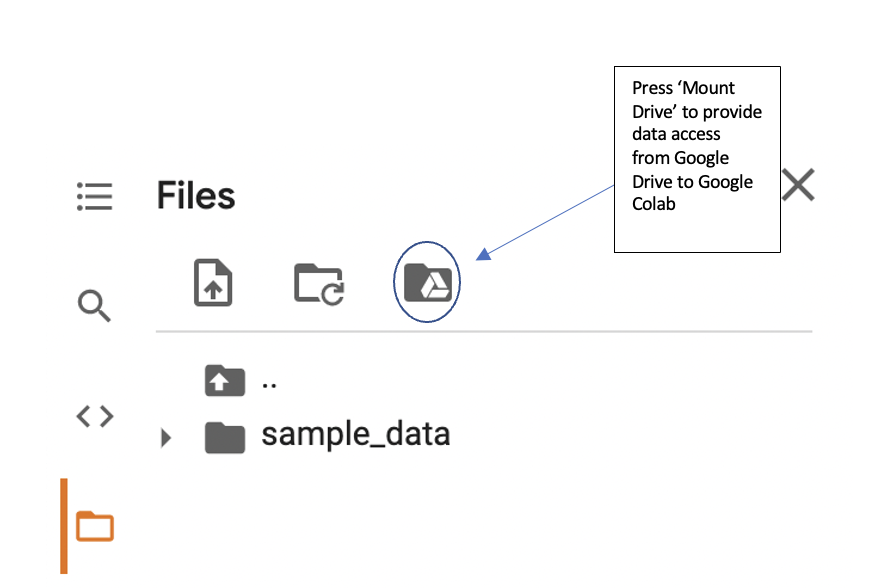

In [618]:
# Used for linking for importing data from Google Drive 

DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/Data/'

## Loading in Data to Compare Sentiment Models

Using data from Kaggle to analyze analyze performance of unsupervised machine learning models (VADER + TextBlob). I want to assess their accuracy and evaluate how trustworthy their conclusions are.

https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news

In [619]:
import pandas as pd

In [620]:
# Load in Kaggle dataset

url = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/all-data.csv'
df = pd.read_csv(url, encoding='latin1')

In [621]:
# Rename columns

df.columns = ['sentiment', 'headline']

In [622]:
df.head()

,sentiment,headline
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [623]:
# Map sentiment analysis

df['sentiment']=df['sentiment'].map({'neutral':0,
                     'positive':1,
                     'negative':-1})

In [624]:
df['headline'].drop_duplicates(inplace=True)

In [625]:
df.head()

,sentiment,headline
0,0,Technopolis plans to develop in stages an area...
1,-1,The international electronic industry company ...
2,1,With the new production plant the company woul...
3,1,According to the company 's updated strategy f...
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


Dataset includes correctly mapped sentiment and raw text in the headline column

## Build VADER Model
- https://github.com/cjhutto/vaderSentiment

In [626]:
# Download necessary dependencies

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [627]:
# Bring in VADER object

sid = SentimentIntensityAnalyzer()

In [628]:
# Apply VADER score to each headlines

df['vader'] = df['headline'].apply(lambda headline: sid.polarity_scores(headline))

- VADER contains a polarity score. Polarity score is a measurement of positive to negative [1,-1]
- VADER subjectivity scores returns a positive, netural, negative ,and compound value. Compound value is a mathematical combination of all three other scores


In [629]:
df.head()

,sentiment,headline,vader
0,0,Technopolis plans to develop in stages an area...,"{'neg': 0.073, 'neu': 0.927, 'pos': 0.0, 'comp..."
1,-1,The international electronic industry company ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,1,With the new production plant the company woul...,"{'neg': 0.038, 'neu': 0.66, 'pos': 0.302, 'com..."
3,1,According to the company 's updated strategy f...,"{'neg': 0.0, 'neu': 0.853, 'pos': 0.147, 'comp..."
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,"{'neg': 0.148, 'neu': 0.657, 'pos': 0.195, 'co..."


In [630]:
# Unpack neg, neu, pos scores

def unpack_scores(row):
  row['neg'] = row['vader']['neg']
  row['neu'] = row['vader']['neu']
  row['pos'] = row['vader']['pos']
  row['comp'] = row['vader']['compound']
  return row

In [631]:
df = df.apply(unpack_scores, axis=1)

In [632]:
df.head()

,sentiment,headline,vader,neg,neu,pos,comp
0,0,Technopolis plans to develop in stages an area...,"{'neg': 0.073, 'neu': 0.927, 'pos': 0.0, 'comp...",0.073,0.927,0.000,-0.2960
1,-1,The international electronic industry company ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
2,1,With the new production plant the company woul...,"{'neg': 0.038, 'neu': 0.66, 'pos': 0.302, 'com...",0.038,0.660,0.302,0.8555
3,1,According to the company 's updated strategy f...,"{'neg': 0.0, 'neu': 0.853, 'pos': 0.147, 'comp...",0.000,0.853,0.147,0.6705
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,"{'neg': 0.148, 'neu': 0.657, 'pos': 0.195, 'co...",0.148,0.657,0.195,0.3485


Confirm that all 4 scores appear in the dataframe

## Build Blob Model
- https://textblob.readthedocs.io/en/dev/

In [633]:
from textblob import TextBlob

- Textblob contains two scores: subjectivity and polarity
- Subjectivity [0,1] determines the truthfulness of a statement (0 objective, 1 subjectvie)
- Polarity [-1,1] determines the postive, negative, or neutral sentiment of a text

In [634]:
# Using polarity score as opposed to subjectivity score

df['blob'] = df['headline'].apply(lambda headline: TextBlob(headline).polarity)

In [635]:
df.head()

,sentiment,headline,vader,neg,neu,pos,comp,blob
0,0,Technopolis plans to develop in stages an area...,"{'neg': 0.073, 'neu': 0.927, 'pos': 0.0, 'comp...",0.073,0.927,0.000,-0.2960,0.083333
1,-1,The international electronic industry company ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.000000
2,1,With the new production plant the company woul...,"{'neg': 0.038, 'neu': 0.66, 'pos': 0.302, 'com...",0.038,0.660,0.302,0.8555,-0.064802
3,1,According to the company 's updated strategy f...,"{'neg': 0.0, 'neu': 0.853, 'pos': 0.147, 'comp...",0.000,0.853,0.147,0.6705,0.000000
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,"{'neg': 0.148, 'neu': 0.657, 'pos': 0.195, 'co...",0.148,0.657,0.195,0.3485,0.500000


- Confirm blob scores appear

## Find Optimal Threshold Values
- VADER + TextBlob documentation does not specify a cutoff for positive, neutral, or negative sentiment
- Experiment with different cutoff values for determining optimal threshold value for pos, neg, neu
  - ie. -1 thru -0.15 is neg, -0.15 to 0.15 is neu, 0.15 to 1 is pos

In [636]:
# Pos, neg, neu sentiment based on input threshold
# Begin by testing 0.15

def create_sentiment_neutral(x, thresh=0.15):
  if x > thresh:
    return 1
  elif x < -1*thresh:
    return -1
  else:
    return 0

In [637]:
# Make sure function operates correctly

df['comp'].map(lambda x: create_sentiment_neutral(x,thresh=0.15))

0      -1
1       0
2       1
3       1
4       1
       ..
4840   -1
4841    0
4842    1
4843    1
4844    0
Name: comp, Length: 4845, dtype: int64

In [638]:
df.head()

,sentiment,headline,vader,neg,neu,pos,comp,blob
0,0,Technopolis plans to develop in stages an area...,"{'neg': 0.073, 'neu': 0.927, 'pos': 0.0, 'comp...",0.073,0.927,0.000,-0.2960,0.083333
1,-1,The international electronic industry company ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.000000
2,1,With the new production plant the company woul...,"{'neg': 0.038, 'neu': 0.66, 'pos': 0.302, 'com...",0.038,0.660,0.302,0.8555,-0.064802
3,1,According to the company 's updated strategy f...,"{'neg': 0.0, 'neu': 0.853, 'pos': 0.147, 'comp...",0.000,0.853,0.147,0.6705,0.000000
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,"{'neg': 0.148, 'neu': 0.657, 'pos': 0.195, 'co...",0.148,0.657,0.195,0.3485,0.500000


Values appear

- Given that there is no set threshold for determing sentiment, try a threshold score of 0 to 0.8
- Using accuracy score to find optimal threshold for pos, neg, neu
- Find tradeoff between accuracy score and misclassifying values as neutral that are pos/neg

In [639]:
# Tet out various threshold values

import numpy as np
from sklearn.metrics import accuracy_score, f1_score
thresh_vals = np.linspace(0, 0.8, 30)

In [640]:
# Apply to VADER

accuracy_scores_vader = {}
for t in thresh_vals:
  df[f'sent_score{t}'] = df['comp'].map(lambda x: create_sentiment_neutral(x, thresh=t))
  acc = accuracy_score(df['sentiment'], df[f'sent_score{t}'])
  f1 = f1_score(df['sentiment'], df[f'sent_score{t}'], average='weighted')
  accuracy_scores_vader[t]=[acc, f1]
  df.drop(columns=f'sent_score{t}', inplace=True)
# df.rename(columns={'sent_score0.0':'sent_score'}, inplace=True)

In [641]:
df.head()

,sentiment,headline,vader,neg,neu,pos,comp,blob
0,0,Technopolis plans to develop in stages an area...,"{'neg': 0.073, 'neu': 0.927, 'pos': 0.0, 'comp...",0.073,0.927,0.000,-0.2960,0.083333
1,-1,The international electronic industry company ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.000000
2,1,With the new production plant the company woul...,"{'neg': 0.038, 'neu': 0.66, 'pos': 0.302, 'com...",0.038,0.660,0.302,0.8555,-0.064802
3,1,According to the company 's updated strategy f...,"{'neg': 0.0, 'neu': 0.853, 'pos': 0.147, 'comp...",0.000,0.853,0.147,0.6705,0.000000
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,"{'neg': 0.148, 'neu': 0.657, 'pos': 0.195, 'co...",0.148,0.657,0.195,0.3485,0.500000


In [642]:
thresh_scores_vader = pd.DataFrame(accuracy_scores_vader).T

In [643]:
thresh_scores_vader.rename(columns={0:'Accuracy', 1:'F1'}, inplace=True)
thresh_scores_vader.reset_index(inplace=True)
thresh_scores_vader.rename(columns={'index': 'threshold_val'}, inplace=True)

In [644]:
thresh_scores_vader

,threshold_val,Accuracy,F1
0,0.000000,0.542828,0.549479
1,0.027586,0.543034,0.548971
2,0.055172,0.544479,0.550345
3,0.082759,0.547781,0.553245
4,0.110345,0.549845,0.555381
5,0.137931,0.550258,0.554564
6,0.165517,0.546543,0.549240
7,0.193103,0.550464,0.552896
8,0.220690,0.554180,0.556355
9,0.248276,0.559959,0.561187


- Optimal vader thresh = 0.30
- Based on F1 score optimization
- Opted for lower accuracy score because I do not want to misclassify an excessive amount of pos/neg sentiments as neutral

In [645]:
# testing thresholds for Blob

accuracy_scores_blob = {}
for t in thresh_vals:
  df[f'sent_score{t}'] = df['blob'].map(lambda x: create_sentiment_neutral(x, thresh=t))
  acc = accuracy_score(df['sentiment'], df[f'sent_score{t}'])
  f1 = f1_score(df['sentiment'], df[f'sent_score{t}'], average='weighted')
  accuracy_scores_blob[t]=[acc, f1]
  df.drop(columns=f'sent_score{t}', inplace=True)

In [646]:
thresh_scores_blob = pd.DataFrame(accuracy_scores_blob).T

In [647]:
thresh_scores_blob.rename(columns={0:'Accuracy', 1:'F1'}, inplace=True)

In [648]:
thresh_scores_blob.reset_index(inplace=True)
thresh_scores_blob.rename(columns={'index': 'threshold_val'}, inplace=True)

In [649]:
thresh_scores_blob

,threshold_val,Accuracy,F1
0,0.000000,0.491022,0.500018
1,0.027586,0.494118,0.501431
2,0.055172,0.511042,0.512568
3,0.082759,0.522601,0.518851
4,0.110345,0.547575,0.532718
5,0.137931,0.566357,0.540672
6,0.165517,0.565738,0.531831
7,0.193103,0.575645,0.534037
8,0.220690,0.583488,0.527446
9,0.248276,0.585759,0.525343


- Optimal Blob thresh = 0.14
- Based on F1 score optimization
- Opted for lower accuracy score because I do not want to misclassify an excessive amount of pos/neg sentiments as neutral

In [650]:
# Apply VADER and Blob scores based on thresholds

df['comp_abs']=df['comp'].map(lambda x: create_sentiment_neutral(x))
df['blob_abs']=df['blob'].map(lambda x: create_sentiment_neutral(x))

In [651]:
df.head()

,sentiment,headline,vader,neg,neu,pos,comp,blob,comp_abs,blob_abs
0,0,Technopolis plans to develop in stages an area...,"{'neg': 0.073, 'neu': 0.927, 'pos': 0.0, 'comp...",0.073,0.927,0.000,-0.2960,0.083333,-1,0
1,-1,The international electronic industry company ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.000000,0,0
2,1,With the new production plant the company woul...,"{'neg': 0.038, 'neu': 0.66, 'pos': 0.302, 'com...",0.038,0.660,0.302,0.8555,-0.064802,1,0
3,1,According to the company 's updated strategy f...,"{'neg': 0.0, 'neu': 0.853, 'pos': 0.147, 'comp...",0.000,0.853,0.147,0.6705,0.000000,1,0
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,"{'neg': 0.148, 'neu': 0.657, 'pos': 0.195, 'co...",0.148,0.657,0.195,0.3485,0.500000,1,1


## Reconcile difference between VADER and Blob conclusions
- Determine the best rules for handling difference between VADER + TextBlob

In [652]:
# Column to show where VADER and Blob agree
# Column to show where VADER and Blob differ

df['same'] = (df['comp_abs']==df['blob_abs'])
df['c_b'] = df['comp']-df['blob']

In [653]:
# Column to show where VADER and Blob disagree
# DF where VADER and blob agree

df_diff = df[df['same']!=True].copy()
df_same = df[df['same']==True].copy()

In [654]:
# Show accuracy of VADER + TextBlob when they agree

same_blob_acc = accuracy_score(df_same['sentiment'], df_same['blob_abs'])
same_vader_acc = accuracy_score(df_same['sentiment'], df_same['comp_abs'])
print(f"Same: Blob Acc > {same_blob_acc}")
print(f"Same: Vader Acc > {same_vader_acc}")

Same: Blob Acc > 0.6729585556011489
Same: Vader Acc > 0.6729585556011489


When the scores are the same, of course it doesn't matter which model is chosen

In [655]:
# Show accuracy of VADER + TextBlob when they differ

diff_blob_acc = accuracy_score(df_diff['sentiment'], df_diff['blob_abs'])
diff_vader_acc = accuracy_score(df_diff['sentiment'], df_diff['comp_abs'])
print(f"Diff: Blob Acc > {diff_blob_acc}")
print(f"Diff: Vader Acc > {diff_vader_acc}")

Diff: Blob Acc > 0.4634551495016611
Diff: Vader Acc > 0.4260797342192691


- When the scores are different, Vader compound is a more accurate scoring method
- Scores are less accurate when VADER and Blob disagree

In [656]:
print('---------BASELINE---------')
print(df['sentiment'].value_counts(1))
print('---------SAME---------')
print(df_same['sentiment'].value_counts(1))
print('---------DIFFERENT---------')
print(df_diff['sentiment'].value_counts(1))

---------BASELINE---------
 0    0.594014
 1    0.281321
-1    0.124665
Name: sentiment, dtype: float64
---------SAME---------
 0    0.668034
 1    0.240460
-1    0.091506
Name: sentiment, dtype: float64
---------DIFFERENT---------
 0    0.519103
 1    0.322674
-1    0.158223
Name: sentiment, dtype: float64


- When VADER and Blob match -> mainly neutral sentiment
- When VADER and Blob differ -> mainly pos/neg sentiment compared to neutral

In [657]:
# Check overall accuracy of VADER vs. Blob

print(accuracy_score(df['sentiment'], df['comp_abs']))
print(accuracy_score(df['sentiment'], df['blob_abs']))

0.5502579979360165
0.5688338493292053


TextBlob is more accurate than VADER

## Methodology for handling large differences in concensus
- As a not: c_b represents the difference between the compound VADER score and the TextBlob score
  - Measures how much they differ

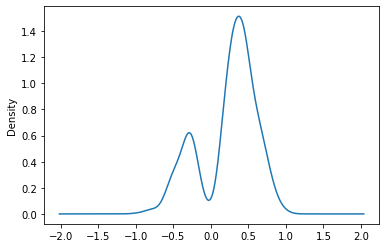

In [658]:
# Distribution of differences

df_diff['c_b'].plot(kind='kde')

Most of the density is between -0.5 & 0.5

In [659]:
# Summary of distribution

df_diff['c_b'].describe()

count    2408.000000
mean        0.235155
std         0.377798
min        -1.001900
25%         0.090600
50%         0.318200
75%         0.492252
max         1.024067
Name: c_b, dtype: float64

- Largest disparity betweeen compound and Blob score on the negative side is -1.001
- Largest disparity between compound and Blob score on the postive side is 1.02

In [660]:
# High CB score = VADER > Blob
# Low CB score = VADER < Blob

df_c_b_lower = df_diff[df_diff['c_b']<=df_diff['c_b'].quantile(0.10)]
df_c_b_upper = df_diff[df_diff['c_b']>=df_diff['c_b'].quantile(0.90)]
print(len(df_c_b_lower))
print(len(df_c_b_upper))

241
248


- Lower represents when compound minus blob is very small (bottom 10% of values)
- Upper represents when compound minus blob is very large (top 90% of values)
- Note: all of these values are where blob and vader disagree

In [661]:
# Inspect sentiment when they disagree at extreme levels (top 90%/bottom 10%)

print('-----------LOWER-----------')
print(df_c_b_lower['sentiment'].value_counts(1))
print('-----------UPPER-----------')
print(df_c_b_upper['sentiment'].value_counts(1))

-----------LOWER-----------
 0    0.464730
-1    0.315353
 1    0.219917
Name: sentiment, dtype: float64
-----------UPPER-----------
 1    0.483871
 0    0.383065
-1    0.133065
Name: sentiment, dtype: float64


When VADER-Blob is very small, tends to be neutral sentiment

When VADER-Blob is very large, tends to be positive sentiment

In [662]:
# Observing where VADER-Blob is small

pd.set_option('display.max_colwidth', None)
df_c_b_lower.sort_values(by='c_b').head(10)

,sentiment,headline,vader,neg,neu,pos,comp,blob,comp_abs,blob_abs,same,c_b
713,1,"The stock price rose 70.0 ores or 0.9 % to close at SEK77 .65 , ending a two-day streak of losses .","{'neg': 0.137, 'neu': 0.863, 'pos': 0.0, 'compound': -0.4019}",0.137,0.863,0.000,-0.4019,0.60,-1,1,False,-1.0019
4237,0,SWOT analysis is just one method of categorization and has its own weaknesses .,"{'neg': 0.172, 'neu': 0.828, 'pos': 0.0, 'compound': -0.3612}",0.172,0.828,0.000,-0.3612,0.60,-1,1,False,-0.9612
718,1,Operating result including non-recurring items rose to EUR 146mn from a loss of EUR 267mn in 2009 .,"{'neg': 0.133, 'neu': 0.867, 'pos': 0.0, 'compound': -0.3182}",0.133,0.867,0.000,-0.3182,0.60,-1,1,False,-0.9182
4808,0,Pentik+Æinen emphasises that the most of the internet contents media houses provide can not be free forever .,"{'neg': 0.144, 'neu': 0.856, 'pos': 0.0, 'compound': -0.4023}",0.144,0.856,0.000,-0.4023,0.45,-1,1,False,-0.8523
4544,0,"The chain has been trying to cut its own costs , pressuring vendors such as fitness equipment manufacturer Precor to slash prices .","{'neg': 0.257, 'neu': 0.661, 'pos': 0.082, 'compound': -0.5423}",0.257,0.661,0.082,-0.5423,0.30,-1,1,False,-0.8423
4521,1,1 Block lamp Harri Koskinen 's light was introduced in 1996 and has been a bestseller ever since .,"{'neg': 0.162, 'neu': 0.838, 'pos': 0.0, 'compound': -0.4404}",0.162,0.838,0.000,-0.4404,0.40,-1,1,False,-0.8404
2990,0,"Jeder Beta-Tester erh+Ælt kostenlos sechs Monate lang Updates und hat laut eigener Aussage die M+¦glichkeit , die finale Version zu beeinflussen .","{'neg': 0.302, 'neu': 0.698, 'pos': 0.0, 'compound': -0.8316}",0.302,0.698,0.000,-0.8316,0.00,-1,0,False,-0.8316
4420,-1,Relations with the City have been further damaged by comments from Mr Ashley criticising City investors and analysts as `` cry babies '' .,"{'neg': 0.303, 'neu': 0.697, 'pos': 0.0, 'compound': -0.8271}",0.303,0.697,0.000,-0.8271,0.00,-1,0,False,-0.8271
1954,0,"Swedish telco TeliaSonera is teaming up with Friends , a Swedish organization against bullying , to fight bullying of children and teenagers via electronic channels .","{'neg': 0.33, 'neu': 0.571, 'pos': 0.098, 'compound': -0.8074}",0.330,0.571,0.098,-0.8074,0.00,-1,0,False,-0.8074
2173,1,"Pre-tax loss totaled EUR 0.3 mn , compared to a loss of EUR 2.2 mn in the first quarter of 2005 .","{'neg': 0.213, 'neu': 0.787, 'pos': 0.0, 'compound': -0.5574}",0.213,0.787,0.000,-0.5574,0.25,-1,1,False,-0.8074


- Generally tend to agree with VADER more, there are confounding positive and negative words 
- Add wordcloud here


In [663]:
# Observing where VADER-Blob is large

pd.set_option('display.max_colwidth', None)
df_c_b_upper.sort_values(by='c_b', ascending=False).head(10)

,sentiment,headline,vader,neg,neu,pos,comp,blob,comp_abs,blob_abs,same,c_b
21,1,"MegaFon 's subscriber base increased 16.1 % in 2009 to 50.5 million users as of December 31 , while its market share by the number of customers amounted to 24 % as of late 2009 , up from 23 % as of late 2008 , according to TeliaSonera estimates .","{'neg': 0.0, 'neu': 0.877, 'pos': 0.123, 'compound': 0.5574}",0.000,0.877,0.123,0.5574,-0.466667,1,-1,False,1.024067
4582,0,"Operating profit for the six-month period decreased from EUR111 .9 m , while sales increased from EUR1 ,275 m , as compared to the corresponding period in 2006 .","{'neg': 0.0, 'neu': 0.815, 'pos': 0.185, 'compound': 0.6124}",0.000,0.815,0.185,0.6124,-0.400000,1,-1,False,1.012400
1386,0,"The Hayward , Calif.-based target designs active , casual and dress footwear , as well as boots and sandals .","{'neg': 0.0, 'neu': 0.663, 'pos': 0.337, 'compound': 0.6808}",0.000,0.663,0.337,0.6808,-0.316667,1,-1,False,0.997467
3836,0,The enterprise value of Maritim Food AS has been determined as approximately EUR15m .,"{'neg': 0.0, 'neu': 0.696, 'pos': 0.304, 'compound': 0.5859}",0.000,0.696,0.304,0.5859,-0.400000,1,-1,False,0.985900
2368,0,"About 72 % of Evraz Group shares are owned by Lanebrook , whose beneficiaries , on the one hand , are Millhouse , the holding company for the assets of billionaire Roman Abramovich and his business partners 50 % ; and Evraz executives Alexander Abramov and Alexander Frolov 50 % , on the other .","{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'compound': 0.836}",0.000,0.806,0.194,0.8360,-0.125000,1,0,False,0.961000
303,1,"There has been some recovery of the base metals prices and increased demand for metals in China , however .","{'neg': 0.077, 'neu': 0.816, 'pos': 0.107, 'compound': 0.1531}",0.077,0.816,0.107,0.1531,-0.800000,1,-1,False,0.953100
1995,0,"As a result of the cancellation , the maximum increase of Citycon 's share capital on the basis of the convertible bonds decreased from EUR 23,383,927.80 to EUR 22,901,784.75 .","{'neg': 0.0, 'neu': 0.847, 'pos': 0.153, 'compound': 0.5423}",0.000,0.847,0.153,0.5423,-0.400000,1,-1,False,0.942300
4458,1,"efficiency improvement measures 20 January 2010 - Finnish stationery and gift retailer Tiimari HEL : TII1V said today that it will continue to improve its operational efficiency , by focusing on its profitable core operations .","{'neg': 0.0, 'neu': 0.609, 'pos': 0.391, 'compound': 0.9403}",0.000,0.609,0.391,0.9403,0.000000,1,0,False,0.940300
4471,1,"The long-standing partnership and commitment enable both parties to develop their respective operations , and ESL Shipping will also have the opportunity to update its fleet and improve its efficiency .","{'neg': 0.0, 'neu': 0.585, 'pos': 0.415, 'compound': 0.936}",0.000,0.585,0.415,0.9360,0.000000,1,0,False,0.936000
3384,0,"The transaction is subject to a final agreement between the parties , approvals of their decision-making bodies and approval by the Finnish Competition Authority .","{'neg': 0.0, 'neu': 0.636, 'pos': 0.364, 'compound': 0.8519}",0.000,0.636,0.364,0.8519,-0.083333,1,0,False,0.935233


Use WordClouds to observe differences

In [664]:
# Bring in packages

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk import RegexpTokenizer

In [665]:
# Bring in stopwords from NLTK

import nltk
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

# Add punctuation and apple
stopwords_list.extend(string.punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [666]:
# Text preprocessor

def preprocess_text(sentence):
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokenizer = RegexpTokenizer(pattern)
    tokens = tokenizer.tokenize(sentence)
    stopped_tokens= [w.lower() for w in tokens  if w.lower() not in stopwords_list]
    return stopped_tokens

In [667]:
#Functionize wordcloud maker

def create_wordcloud(df, sent, stop):

  wordcloud = WordCloud(collocations=True, stopwords=stop)
  df['tokens'] = df['headline'].map(lambda x: preprocess_text(x))
  corpus = df[df['sentiment']==sent]['headline'].to_list()
  corpus = ",".join(corpus)
  wordcloud.generate(corpus)
  return wordcloud

In [668]:
df_same

,sentiment,headline,vader,neg,neu,pos,comp,blob,comp_abs,blob_abs,same,c_b
1,-1,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.000,1.000,0.000,0.0000,0.000000,0,0,True,0.000000
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding HDI printed circuit boards PCBs .,"{'neg': 0.148, 'neu': 0.657, 'pos': 0.195, 'compound': 0.3485}",0.148,0.657,0.195,0.3485,0.500000,1,1,True,-0.151500
7,1,Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .,"{'neg': 0.0, 'neu': 0.879, 'pos': 0.121, 'compound': 0.4404}",0.000,0.879,0.121,0.4404,0.300000,1,1,True,0.140400
10,1,"STORA ENSO , NORSKE SKOG , M-REAL , UPM-KYMMENE Credit Suisse First Boston ( CFSB ) raised the fair value for shares in four of the largest Nordic forestry groups .","{'neg': 0.0, 'neu': 0.689, 'pos': 0.311, 'compound': 0.8176}",0.000,0.689,0.311,0.8176,0.475000,1,1,True,0.342600
13,1,"Clothing retail chain Sepp+Æl+Æ 's sales increased by 8 % to EUR 155.2 mn , and operating profit rose to EUR 31.1 mn from EUR 17.1 mn in 2004 .","{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'compound': 0.6124}",0.000,0.828,0.172,0.6124,0.600000,1,1,True,0.012400
...,...,...,...,...,...,...,...,...,...,...,...,...
4828,-1,"The OMX Helsinki index was 0.33 pct lower at 9,364.80 , while the OMX Helsinki CAP portfolio index was down 0.34 pct at 5,029.25 .","{'neg': 0.091, 'neu': 0.909, 'pos': 0.0, 'compound': -0.296}",0.091,0.909,0.000,-0.2960,-0.155556,-1,-1,True,-0.140444
4833,-1,Hobby Hall 's sales decrease 26 pct due to implementing a new information system that involved changing in the principal of posting sales .,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.000,1.000,0.000,0.0000,0.005682,0,0,True,-0.005682
4834,-1,"In the Baltic states the company reports net sales of EUR 11.9 mn , down from EUR 14.2 mn , and an operative EBIT of EUR -2.2 mn , down from EUR -1.7 mn .","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.000,1.000,0.000,0.0000,-0.103704,0,0,True,0.103704
4840,-1,LONDON MarketWatch -- Share prices ended lower in London Monday as a rebound in bank stocks failed to offset broader weakness for the FTSE 100 .,"{'neg': 0.272, 'neu': 0.656, 'pos': 0.072, 'compound': -0.7269}",0.272,0.656,0.072,-0.7269,-0.500000,-1,-1,True,-0.226900


In [669]:
create_wordcloud(df_same, 1, stopwords_list)

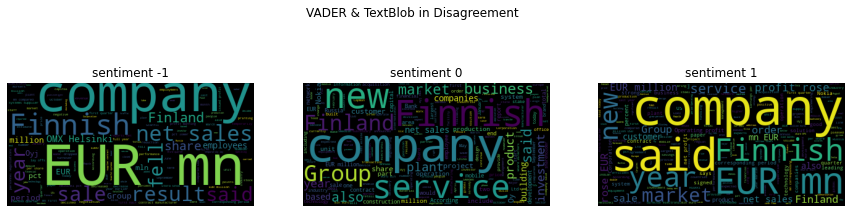

In [670]:
# GOT IT
sent_scores = [-1, 0, 1]
fig = plt.figure(figsize=(15,4))
fig.suptitle('VADER & TextBlob in Disagreement')
for i, sent_ in enumerate(sent_scores):
    ax = fig.add_subplot(1,3,i+1)
    ax.set_title(f"sentiment {sent_}")
    wordcloud = create_wordcloud(df_same, sent_, stopwords_list)
    ax.imshow(wordcloud)
    ax.axis('off')

In [671]:
create_wordcloud(df_same, -1, stopwords_list)

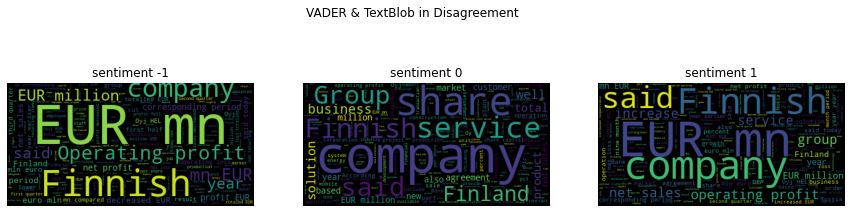

In [672]:
sent_scores = [-1, 0, 1]
fig = plt.figure(figsize=(15,4))
fig.suptitle('VADER & TextBlob in Disagreement')
for i, sent_ in enumerate(sent_scores):
    ax = fig.add_subplot(1,3,i+1)
    ax.set_title(f"sentiment {sent_}")
    wordcloud = create_wordcloud(df_diff, sent_, stopwords_list)
    ax.imshow(wordcloud)
    ax.axis('off')

## Determine Optimal Reconcilliation Rules
- Create rules based approach for optimizing accuracy score given a TextBlob and VADER score

In [673]:
# Determine optimal classification value based on different thresholds
# Potentially add functionality for greater/lesser thresholds

def classification_rules(df):

  # if blob and vader agree use their agreed upon sentiment
  if (df['comp_abs'] == df['blob_abs']):
    return df['comp_abs']
  
  # if they differ - do the following
  else:
    if df['c_b']<-0.13:
      return df['comp_abs']
    elif df['c_b']>0.71:
      return df['comp_abs']
    else:
      return df['comp_abs']

Add apply here with different threshold values

In [674]:
# Apply sentiment based on thresholds

df['rules_sent'] = df.apply(classification_rules, axis=1)

In [675]:
pd.reset_option('^display.', silent=True)
df.head()

,sentiment,headline,vader,neg,neu,pos,comp,blob,comp_abs,blob_abs,same,c_b,rules_sent
0,0,Technopolis plans to develop in stages an area...,"{'neg': 0.073, 'neu': 0.927, 'pos': 0.0, 'comp...",0.073,0.927,0.000,-0.2960,0.083333,-1,0,False,-0.379333,-1
1,-1,The international electronic industry company ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.000000,0,0,True,0.000000,0
2,1,With the new production plant the company woul...,"{'neg': 0.038, 'neu': 0.66, 'pos': 0.302, 'com...",0.038,0.660,0.302,0.8555,-0.064802,1,0,False,0.920302,1
3,1,According to the company 's updated strategy f...,"{'neg': 0.0, 'neu': 0.853, 'pos': 0.147, 'comp...",0.000,0.853,0.147,0.6705,0.000000,1,0,False,0.670500,1
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,"{'neg': 0.148, 'neu': 0.657, 'pos': 0.195, 'co...",0.148,0.657,0.195,0.3485,0.500000,1,1,True,-0.151500,1


In [676]:
# Calculate accurate score

accuracy_score(df['sentiment'], df['rules_sent'])

0.5502579979360165

- Baseline score of 55%, compared to a random guess of 33%

In [677]:
df.head()

,sentiment,headline,vader,neg,neu,pos,comp,blob,comp_abs,blob_abs,same,c_b,rules_sent
0,0,Technopolis plans to develop in stages an area...,"{'neg': 0.073, 'neu': 0.927, 'pos': 0.0, 'comp...",0.073,0.927,0.000,-0.2960,0.083333,-1,0,False,-0.379333,-1
1,-1,The international electronic industry company ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.000000,0,0,True,0.000000,0
2,1,With the new production plant the company woul...,"{'neg': 0.038, 'neu': 0.66, 'pos': 0.302, 'com...",0.038,0.660,0.302,0.8555,-0.064802,1,0,False,0.920302,1
3,1,According to the company 's updated strategy f...,"{'neg': 0.0, 'neu': 0.853, 'pos': 0.147, 'comp...",0.000,0.853,0.147,0.6705,0.000000,1,0,False,0.670500,1
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,"{'neg': 0.148, 'neu': 0.657, 'pos': 0.195, 'co...",0.148,0.657,0.195,0.3485,0.500000,1,1,True,-0.151500,1


In [678]:
# Testing different outcomes for lower threshold 

print(accuracy_score(df_c_b_lower['sentiment'], df_c_b_lower['blob_abs']))
print(accuracy_score(df_c_b_lower['sentiment'], df_c_b_lower['comp_abs']))
print(accuracy_score(df_c_b_lower['sentiment'], np.zeros(shape=len(df_c_b_lower))))
print(accuracy_score(df_c_b_lower['sentiment'], np.ones(shape=len(df_c_b_lower))))
print(accuracy_score(df_c_b_lower['sentiment'], np.full(shape=len(df_c_b_lower), fill_value=-1)))


0.37344398340248963
0.46473029045643155
0.46473029045643155
0.21991701244813278
0.3153526970954357


Accuracy score is highest for VADER analysis

In [679]:
print(accuracy_score(df_c_b_upper['sentiment'], df_c_b_upper['blob_abs']))
print(accuracy_score(df_c_b_upper['sentiment'], df_c_b_upper['comp_abs']))
print(accuracy_score(df_c_b_upper['sentiment'], np.zeros(shape=len(df_c_b_upper))))
print(accuracy_score(df_c_b_upper['sentiment'], np.ones(shape=len(df_c_b_upper))))
print(accuracy_score(df_c_b_upper['sentiment'], np.full(shape=len(df_c_b_upper), fill_value=-1)))

0.375
0.4879032258064516
0.38306451612903225
0.4838709677419355
0.13306451612903225


Accuracy score is highest for VADER analysis

When VADER and Blob at different quantiles, try imputing a score of -1, 0, 1, VADER or TextBlob

In [680]:
# Test out blob, VADER, 0, 1, -1 for various thresholds of cb values

lower_ = np.linspace(0,0.15,16)
upper_ = np.linspace(stop=0.85,start=1.00,num=16)
lower_upper = zip(lower_, upper_)
thresh_vals = {}
for lower, upper in lower_upper:
  df_c_b_lower = df[df['c_b']<=df['c_b'].quantile(lower)]
  df_c_b_upper = df[df['c_b']>=df['c_b'].quantile(upper)]
  blob_acc_upper = accuracy_score(df_c_b_upper['sentiment'], df_c_b_upper['blob_abs'])
  blob_acc_lower = accuracy_score(df_c_b_lower['sentiment'], df_c_b_lower['blob_abs'])
  vader_acc_upper = accuracy_score(df_c_b_upper['sentiment'], df_c_b_upper['comp_abs'])
  vader_acc_lower = accuracy_score(df_c_b_lower['sentiment'], df_c_b_lower['comp_abs'])
  upper_zeros = accuracy_score(df_c_b_upper['sentiment'], np.zeros(shape=len(df_c_b_upper)))
  lower_zeros = accuracy_score(df_c_b_lower['sentiment'], np.zeros(shape=len(df_c_b_lower)))
  upper_ones = accuracy_score(df_c_b_upper['sentiment'], np.ones(shape=len(df_c_b_upper)))
  lower_ones = accuracy_score(df_c_b_lower['sentiment'], np.ones(shape=len(df_c_b_lower)))
  upper_neg = accuracy_score(df_c_b_upper['sentiment'], np.full(shape=len(df_c_b_upper), fill_value=-1))
  lower_neg = accuracy_score(df_c_b_lower['sentiment'], np.full(shape=len(df_c_b_lower), fill_value=-1))



  thresh_vals[(upper, lower)] = [blob_acc_upper, blob_acc_lower, vader_acc_upper, vader_acc_lower,
                                 upper_zeros, lower_zeros, upper_ones, lower_ones, upper_neg, lower_neg]


In [681]:
df_fresh = pd.DataFrame(thresh_vals).T

In [682]:
df_fresh.columns = ['blob_upper', 'blob_lower', 'vader_upper', 'vader_lower', 'upper_0',
                 'lower_0', 'upper_1', 'lower_1', 'upper_neg', 'lower_neg']

In [683]:
# Best performer is 0.97 VADER
df_fresh.iloc[:,[0,2,4,6,8]]

,,blob_upper,vader_upper,upper_0,upper_1,upper_neg
1.00,0.00,0.000000,1.000000,0.000000,1.000000,0.000000
0.99,0.01,0.464286,0.375000,0.285714,0.375000,0.339286
0.98,0.02,0.355769,0.490385,0.317308,0.480769,0.201923
0.97,0.03,0.308219,0.520548,0.308219,0.513699,0.178082
0.96,0.04,0.371981,0.483092,0.367150,0.478261,0.154589
0.95,0.05,0.366255,0.497942,0.370370,0.493827,0.135802
0.94,0.06,0.389262,0.489933,0.385906,0.486577,0.127517
0.93,0.07,0.385294,0.497059,0.385294,0.494118,0.120588
0.92,0.08,0.415816,0.466837,0.377551,0.464286,0.158163
0.91,0.09,0.417431,0.467890,0.392202,0.465596,0.142202


On upper threshold - VADER 0.97 is the highest performer

In [684]:
# Best performer is 0.15 VADER
df_fresh.iloc[:,[1,3,5,7,9]]

,,blob_lower,vader_lower,lower_0,lower_1,lower_neg
1.00,0.00,1.000000,0.000000,0.000000,1.000000,0.000000
0.99,0.01,0.489796,0.306122,0.448980,0.326531,0.224490
0.98,0.02,0.362832,0.486726,0.433628,0.265487,0.300885
0.97,0.03,0.369863,0.458904,0.452055,0.226027,0.321918
0.96,0.04,0.350515,0.458763,0.427835,0.226804,0.345361
0.95,0.05,0.372951,0.463115,0.467213,0.221311,0.311475
0.94,0.06,0.377419,0.454839,0.441935,0.251613,0.306452
0.93,0.07,0.395349,0.459302,0.433140,0.279070,0.287791
0.92,0.08,0.438776,0.428571,0.474490,0.244898,0.280612
0.91,0.09,0.440367,0.442661,0.458716,0.245413,0.295872


On lower threshold - VADER 0.15 is the highest performer

In [685]:
# Threshold values

print(df['c_b'].quantile(0.15))
print(df['c_b'].quantile(0.97))

-0.13636363636363635
0.710968


# Extract, Transform, Load Data
- Performing initial test with Apple

In [686]:
# Function to read in csv and exclude 'bad sources'

def read_in_data(filepath):
    df = pd.read_csv(filepath)
    df.drop(columns='Unnamed: 0', inplace=True)
    df = df[~df['source2'].isin(bad_sources)].copy()
    return df

Manually checked out 500+ media sources and eliminated sources that were either advertisements or provided irrelevant information

In [687]:
# Sources to exlude

bad_sources = ['LatestLY', 'iMore', 'Phandroid - News for Android', 'Internet', 'AnandTech', 'Justcreative.com',
      'Raywenderlich.com', 'Lifehacker Australia', 'News18', 'Zee Business', 'Geeky Gadgets', 'Business Wire',
      'Digital Information World', 'Madshrimps.be', 'Theinventory.com', 'Ozbargain.com.au', 'Www.bgr.in',
      "Paul Tan's Automotive News", 'Livemint', 'Todayifoundout.com', 'Hotukdeals.com', 'Thefutoncritic.com',
      'Applelinkage.com', 'Worldsoccertalk.com', '9to5Toys', 'Torrentfreak.com', 'Slickdeals.net',
      'Rock Paper Shotgun', 'Idownloadblog.com', 'Justinobeirne.com', 'Everydaycarry.com', 'Ars Technica',
      'Intheknow.com', 'Yanko Design', 'Lefsetz.com', 'Android Community', '/FILM', 'Droid Life',
      'Moneysavingmom.com', 'WDVM 25', 'Nextjs.org', 'ComingSoon.net', 'Hip2save.com', 'Giveawayoftheday.com',
      'Wptavern.com', 'Visual.ly', 'Denton Record Chronicle', 'Pocket Gamer', 'Moneycontrol',
      'Commonsensewithmoney.com', 'PC Gamer', 'Livedoor.jp', 'Trendhunter.com', 'Twit.tv', 'Prtimes.jp',
      'NWAOnline', 'Raw Story', 'MobiHealthNews', 'guru3d.com', 'Travelcodex.com', 'T3 US/CA', 'Ctvnews.ca',
       'Macitynet.it', 'The Hindu', 'Thekitchn.com', 'Omgubuntu.co.uk', 'DC Rainmaker', 'Foodgawker.com',
       'Just Jared', 'Mediagazer.com', 'Theshutterwhale.com', 'Uark.edu', 'Sputnik International', 'Pinkbike.com',
       'CNA', 'EurekAlert', 'Energy-storage.news', 'Rogerebert.com', 'Driving', 'Phys.Org', 'The Times of India',
       'Eonline.com', 'DIYphotography', 'Food52.com', 'BMWBLOG','Eonline', 'redmondpie', 'Brooklyn Vegan', 'MMA Fighting', 'Spoilertv', 'Hotukdeals', 
        'Celebitchy', 'Michaelgeist', 'Helloglow', 'Robb Report', 'Carandbike', 'POPSUGAR',
        'Slickdeals', 'Pyimagesearch', 'Purseblog', 'BroBible', 'Clarkesworldmagazine', 'TheGrio',
        'Heimdalsecurity', "Tom's Guide", 'Siliconera', 'Gamasutra', 'Dansdeals', 'Touringplans',
        'Ehl', 'City A', 'Southernsavers', 'Dpreview', 'Marksdailyapple', '2dopeboyz',
         'SYFY WIRE', 'Screenanarchy', 'Top Speed', 'CBS Sports', 'Yahoo Entertainment',
         'Hollywood Life', 'Iphone-mania']

In [688]:
appl_url = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/news_articles/hourly_apple_articles_614_618'
apple = read_in_data(appl_url)

## Drop data after removing continued join

In [689]:
def data_drop(df):
  df.dropna(subset=['description', 'content', 'title'], inplace=True)
  return df

In [690]:
apple = data_drop(apple)

In [691]:
# Ensure data load in correctly

apple.head()

,source,author,title,description,url,urlToImage,publishedAt,content,results,source2
0,"{'id': 'mashable', 'name': 'Mashable'}",Nicole Gallucci,'The Morning Show' Season 2 trailer is high dr...,The Morning Show's engaging first season ended...,https://mashable.com/video/the-morning-show-se...,https://mondrian.mashable.com/2021%252F06%252F...,2021-06-14T13:57:23Z,The Morning Show's engaging first season ended...,124.0,Mashable
1,"{'id': None, 'name': 'MacRumors'}",Joe Rossignol,Spatial Audio on Apple Music Promoted in New '...,Just days after the launch of Spatial Audio on...,https://www.macrumors.com/2021/06/14/apple-mus...,https://images.macrumors.com/t/g9RXcMKfyt1t0zX...,2021-06-14T13:43:37Z,iOS 15 introduces new features for FaceTime ca...,124.0,MacRumors
2,"{'id': None, 'name': 'Global News'}",alancross1,Weekly survey: Do you care about better the qu...,<ol><li>Weekly survey: Do you care about bette...,https://globalnews.ca/news/7947494/weekly-surv...,https://globalnews.ca/wp-content/uploads/2019/...,2021-06-14T13:27:07Z,"Earlier this month, Apple Music launched its S...",124.0,Global News
3,"{'id': None, 'name': 'StockNews.com'}",Christian Tharp,Is Apple Setting up for a Big Move?,Apple Inc. (AAPL) stock has been trading in a ...,https://stocknews.com/news/aapl-is-apple-setti...,https://assets.entrepreneur.com/providers/stoc...,2021-06-14T13:37:11Z,This story originally appeared on StockNewsApp...,124.0,StockNews
4,"{'id': None, 'name': 'New York Times'}",The New York Times,Live Updates: Bipartisan Infrastructure Plan L...,A plan from a bipartisan group of lawmakers do...,https://www.nytimes.com/live/2021/06/14/us/pol...,https://static01.nyt.com/images/2021/06/14/len...,2021-06-14T13:02:48Z,"LiveUpdated June 14, 2021, 9:00 a.m. ET\r\nJun...",124.0,New York Times


## Clean conent and description and join into one column

In [692]:
def content_clearer_join(df):
    
    df['content']=df['content'].split('[')[0].replace('…', '').replace('\r\n', '')\
                                                .replace('\xa0', '').replace('&amp', '').strip()
    df['description']=df['content'].split('[')[0].replace('…', '').replace('\r\n', '')\
                                                .replace('\xa0', '').replace('&amp', '').strip()
    
    if (df['description'][:100] == df['content'][:100]):
        df['cont_joined'] = df['title']+ '; ' +df['description']
    
    else:
        df['cont_joined'] = df['title']+ '; ' +df['description'] + '; ' +df['content']
    
    return df

In [693]:
apple=apple.apply(content_clearer_join, axis=1)

In [694]:
def remove_columns(df):
    df.drop(columns=['source', 'author', 'url', 'urlToImage'], inplace=True)
    return df

In [695]:
apple=remove_columns(apple)

In [696]:
# Confirm cont_joined is in dataframe

apple.head(5)

,title,description,publishedAt,content,results,source2,cont_joined
0,'The Morning Show' Season 2 trailer is high dr...,The Morning Show's engaging first season ended...,2021-06-14T13:57:23Z,The Morning Show's engaging first season ended...,124.0,Mashable,'The Morning Show' Season 2 trailer is high dr...
1,Spatial Audio on Apple Music Promoted in New '...,iOS 15 introduces new features for FaceTime ca...,2021-06-14T13:43:37Z,iOS 15 introduces new features for FaceTime ca...,124.0,MacRumors,Spatial Audio on Apple Music Promoted in New '...
2,Weekly survey: Do you care about better the qu...,"Earlier this month, Apple Music launched its S...",2021-06-14T13:27:07Z,"Earlier this month, Apple Music launched its S...",124.0,Global News,Weekly survey: Do you care about better the qu...
3,Is Apple Setting up for a Big Move?,This story originally appeared on StockNewsApp...,2021-06-14T13:37:11Z,This story originally appeared on StockNewsApp...,124.0,StockNews,Is Apple Setting up for a Big Move?; This stor...
4,Live Updates: Bipartisan Infrastructure Plan L...,"LiveUpdatedJune 14, 2021, 9:00 a.m. ETJune 14,...",2021-06-14T13:02:48Z,"LiveUpdatedJune 14, 2021, 9:00 a.m. ETJune 14,...",124.0,New York Times,Live Updates: Bipartisan Infrastructure Plan L...


In [697]:
def set_idx(df):
    df['publishedAt'] = pd.to_datetime(df['publishedAt'])
    df.set_index('publishedAt', inplace=True)
    df.index = df.index.tz_convert('US/Eastern')
    df.sort_index(inplace=True)
    df['hour'] = df.index.hour
    df['day']=df.index.day
    return df

In [698]:
apple = set_idx(apple)

In [699]:
# Confirm index is loaded in

apple.head()

,title,description,content,results,source2,cont_joined,hour,day
publishedAt,,,,,,,,
2021-06-14 09:00:00-04:00,‘The Morning Show’ Season 2 Teaser Reveals the...,Apple TV+ released the first teaser and premie...,Apple TV+ released the first teaser and premie...,124.0,TheWrap,‘The Morning Show’ Season 2 Teaser Reveals the...,9,14
2021-06-14 09:00:00-04:00,Lululemon (NASDAQ: LULU) Lines Up For A Run At...,This story originally appeared on MarketBeatFo...,This story originally appeared on MarketBeatFo...,124.0,MarketBeat,Lululemon (NASDAQ: LULU) Lines Up For A Run At...,9,14
2021-06-14 09:00:02-04:00,Fitbit Luxe review: A luxury fitness tracker f...,Source: Jeramy Johnson / Android CentralIt's n...,Source: Jeramy Johnson / Android CentralIt's n...,124.0,Android Central,Fitbit Luxe review: A luxury fitness tracker f...,9,14
2021-06-14 09:00:26-04:00,We can’t believe how cheap these Apple product...,"Technically, Prime Day deals aren’t officially...","Technically, Prime Day deals aren’t officially...",124.0,Digital Trends,We can’t believe how cheap these Apple product...,9,14
2021-06-14 09:00:33-04:00,"‘The Morning Show’ Season 2 Trailer: Aniston, ...",Apple has announced its flagship drama series ...,Apple has announced its flagship drama series ...,124.0,IndieWire,"‘The Morning Show’ Season 2 Trailer: Aniston, ...",9,14


In [700]:
def add_sentiment(df):
  df['vader'] = df['cont_joined'].apply(lambda headline: sid.polarity_scores(headline))
  df = df.apply(unpack_scores, axis=1)
  df['blob'] = df['cont_joined'].apply(lambda headline: TextBlob(headline).polarity)
  df['comp_abs']=df['comp'].map(lambda x: create_sentiment_neutral(x,thresh=0.3))
  df['blob_abs']=df['blob'].map(lambda x: create_sentiment_neutral(x,thresh=0.14))
  df['c_b'] = df['comp']-df['blob']
  df['Sentiment'] = df.apply(classification_rules, axis=1)
  df.drop(columns='vader', inplace=True)
  return df
  

In [701]:
apple=add_sentiment(apple)

In [702]:
# Confirm absolute sentiment appears in dataframe

apple

,title,description,content,results,source2,cont_joined,hour,day,neg,neu,pos,comp,blob,comp_abs,blob_abs,c_b,Sentiment
publishedAt,,,,,,,,,,,,,,,,,
2021-06-14 09:00:00-04:00,‘The Morning Show’ Season 2 Teaser Reveals the...,Apple TV+ released the first teaser and premie...,Apple TV+ released the first teaser and premie...,124.0,TheWrap,‘The Morning Show’ Season 2 Teaser Reveals the...,9,14,0.133,0.867,0.000,-0.7096,0.125000,-1,0,-0.834600,-1
2021-06-14 09:00:00-04:00,Lululemon (NASDAQ: LULU) Lines Up For A Run At...,This story originally appeared on MarketBeatFo...,This story originally appeared on MarketBeatFo...,124.0,MarketBeat,Lululemon (NASDAQ: LULU) Lines Up For A Run At...,9,14,0.000,0.930,0.070,0.4173,0.317500,1,1,0.099800,1
2021-06-14 09:00:02-04:00,Fitbit Luxe review: A luxury fitness tracker f...,Source: Jeramy Johnson / Android CentralIt's n...,Source: Jeramy Johnson / Android CentralIt's n...,124.0,Android Central,Fitbit Luxe review: A luxury fitness tracker f...,9,14,0.035,0.790,0.175,0.6593,0.257143,1,1,0.402157,1
2021-06-14 09:00:26-04:00,We can’t believe how cheap these Apple product...,"Technically, Prime Day deals aren’t officially...","Technically, Prime Day deals aren’t officially...",124.0,Digital Trends,We can’t believe how cheap these Apple product...,9,14,0.047,0.856,0.098,0.5499,0.271429,1,1,0.278471,1
2021-06-14 09:00:33-04:00,"‘The Morning Show’ Season 2 Trailer: Aniston, ...",Apple has announced its flagship drama series ...,Apple has announced its flagship drama series ...,124.0,IndieWire,"‘The Morning Show’ Season 2 Trailer: Aniston, ...",9,14,0.041,0.798,0.162,0.7096,0.195455,1,1,0.514145,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-18 15:49:01-04:00,Apple iPhone 6+ Firmware iOS 12.5.4 (16H50),iOS12 brings performance improvements and exci...,iOS12 brings performance improvements and exci...,67.0,Softpedia,Apple iPhone 6+ Firmware iOS 12.5.4 (16H50); i...,15,18,0.000,0.766,0.234,0.8555,0.241818,1,1,0.613682,1
2021-06-18 15:51:15-04:00,Apple has put an end to Space Grey iMac Pro ac...,"About three months ago, Apple announced that i...","About three months ago, Apple announced that i...",67.0,MobileSyrup,Apple has put an end to Space Grey iMac Pro ac...,15,18,0.000,0.942,0.058,0.1027,-0.033333,0,0,0.136033,0
2021-06-18 15:54:56-04:00,What Is Okcoin?,Cryptocurrency trading is a relatively new mar...,Cryptocurrency trading is a relatively new mar...,67.0,Investopedia,What Is Okcoin?; Cryptocurrency trading is a r...,15,18,0.000,0.841,0.159,0.6901,0.189394,1,1,0.500706,1


In [703]:
# def resample(df):
#   df = df.resample('h').mean()
#   df.dropna(inplace=True)
#   df=df[~df['hour'].isin([16])].copy()
#   df['results'] = df['results'].astype('int')
#   return df


In [704]:
# FULL ETL FUNCTION:

def etl(filepath):

    # Load Data
    df = pd.read_csv(filepath)

    df['publishedAt'] = pd.to_datetime(df['publishedAt'])
    df.set_index('publishedAt', inplace=True)
    df.index = df.index.tz_convert('US/Eastern')
    df.sort_index(inplace=True)
    df['hour'] = df.index.hour
    df['day']=df.index.day

    # Drop unncessary column and remove bad sources
    if 'Unnamed: 0' in df.columns:
      df.drop(columns='Unnamed: 0', inplace=True)
    else:
      pass
    df = df[~df['source2'].isin(bad_sources)].copy()

    # Drop null columns
    df.dropna(subset=['description', 'content', 'title'], inplace=True)
    
    # Create column that we will NLP models will be applied to
    df=df.apply(content_clearer_join, axis=1)
    
    # Drop further unnecessary columns 
    df.drop(columns=['source', 'author', 'url', 'urlToImage'], axis=1,inplace=True)

    # Drop dupblicates
    df.drop_duplicates(inplace=True)

    return df

In [705]:
# Apple ETL function to hourly raw data

list_of_df = [f'{DATA_PATH}Raw_data/hourly_am_articles_614_618',
              f'{DATA_PATH}Raw_data/hourly_am_articles_621_625',
              f'{DATA_PATH}Raw_data/hourly_apple_articles_614_618',
              f'{DATA_PATH}Raw_data/hourly_apple_articles_621_625',
              f'{DATA_PATH}Raw_data/hourly_fb_articles_614_618',
              f'{DATA_PATH}Raw_data/hourly_fb_articles_621_625',
              f'{DATA_PATH}Raw_data/hourly_goog_articles_614_618',
              f'{DATA_PATH}Raw_data/hourly_goog_articles_621_626',
              f'{DATA_PATH}Raw_data/hourly_msft_articles_614_618',
              f'{DATA_PATH}Raw_data/hourly_msft_articles_621_625',
              f'{DATA_PATH}Raw_data/hourly_nf_articles_614_618',
              f'{DATA_PATH}Raw_data/hourly_nf_articles_621_625']
df_name = ['am1', 'am2', 'apple1', 'apple2', 'fb1', 'fb2', 'goog1', 'goog2', 'msft1', 'msft2','nflx1', 'nflx2']

In [706]:
# If etl_create = False: do not create csv files
# If etl_create = True: create etl csv files
import os

etl_create=False
DATA_ETL= f'{DATA_PATH}/crisp_data/'
os.makedirs(DATA_ETL, exist_ok=True)

In [707]:
## Create dataframes using ETL function

if etl_create:
  for file, name in zip(list_of_df, df_name):
    df = etl(file)
    df = add_sentiment(df)
    df.to_csv(f"/content/drive/MyDrive/Colab Notebooks/Data/crisp_data/df_etl_{name}.csv")
else:
  pass
  print('Did not create new folder')


Did not create new folder


# NLP Analysis w/Vectorization and RFM
- Tokenize and clean text - NLTK has a tokenizer
- Remove stopworks using NLTK - potentially add words - remove punctuation - use freqdist to see if it looks good
- Able to build word cloud at this point
- Possible stem/lemmatize
- Vectorize text with WordCount Vectorizer and TF-IDF - has a built in pipeline to add tokenization/stopwords/etc
- Train test split and use RF and get feature names out of sparse matrix to get words that made an impact
- Use pipelines to enhance results

In [708]:
# Bring in necessary packages

from nltk import FreqDist,word_tokenize,RegexpTokenizer,TweetTokenizer
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer

In [709]:
import pandas as pd
import numpy as np
url = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_apple1.csv'

# crips_data_path = f'{DATA_PATH}crisp_data/df_etfl_apple1.csv'
# Adjust this to end at path and then they can manually feed in csv with f string

apple = pd.read_csv(url)


In [710]:
# Create corpus from Apple DF

corpus = apple['cont_joined'].to_list()

## Word Tokenizer

In [711]:
# Tokenize corpus

import nltk
nltk.download('punkt')
from nltk import FreqDist,word_tokenize

tokens = word_tokenize(','.join(corpus))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [712]:
tokens[:5]

['Lululemon', '(', 'NASDAQ', ':', 'LULU']

In [713]:
# Bring in stopwords from NLTK

import nltk
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

# Add punctuation and apple
stopwords_list.extend(string.punctuation)
stopwords_list.append('’')
stopwords_list.append('‘')
stopwords_list.append("apple")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [714]:
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [715]:
# Filter out stopwords

stopped_tokens= [w.lower() for w in tokens  if w.lower() not in stopwords_list]
stopped_tokens[:50]

['lululemon',
 'nasdaq',
 'lulu',
 'lines',
 'run',
 'highs',
 'story',
 'originally',
 'appeared',
 'marketbeatfor',
 'fashion',
 'specifically',
 'athletic',
 'fashion',
 'company',
 'lululemon',
 'nasdaq',
 'lulu',
 'trading',
 'much',
 'like',
 'tech',
 'stock',
 'maybe',
 'morning',
 'show',
 'season',
 '2',
 'teaser',
 'reveals',
 'fallout',
 'alex',
 'bradley',
 'on-air',
 'bombshell',
 'video',
 'tv+',
 'released',
 'first',
 'teaser',
 'premiere',
 'date',
 'second',
 'season',
 '“',
 'morning',
 'show',
 '”',
 'monday',
 'revealing']

In [716]:
# Confirm there are no stopwords or punctuation

freq = FreqDist(stopped_tokens)
pd.DataFrame(freq.items()).sort_values(by=1, ascending=False).nlargest(30, columns=1)

,0,1
101,new,764
60,'s,566
76,day,300
156,2021,287
279,ios,253
34,first,229
239,one,224
99,series,216
448,amazon,211
17,tech,206


## RegEx Tokenizer

In [717]:
# Pattern to handle hypothesis

pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(pattern)

In [718]:
# Create tokens using RegExp tokenizer

tokens = tokenizer.tokenize(','.join(corpus))

In [719]:
# Filter out stopwords

stopped_tokens= [w.lower() for w in tokens  if w.lower() not in stopwords_list]
stopped_tokens[:5]

['lululemon', 'nasdaq', 'lulu', 'lines', 'run']

In [720]:
# Top tokens in RegExp tokenizer

freq = FreqDist(stopped_tokens)
pd.DataFrame(freq.items()).sort_values(by=1, ascending=False).nlargest(30, columns=1)

,0,1
97,new,776
72,day,320
258,ios,259
31,tv,251
33,first,250
221,one,245
17,tech,223
95,series,219
419,amazon,218
303,google,211


- Removes 's
- Removes numbers

In [721]:
# Bring in lemmatizer

from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [722]:
# Test lemmatizer

lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('feet')

'foot'

In [723]:
def preprocess_text(sentence):

  pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
  tokenizer = RegexpTokenizer(pattern)
  tokens = tokenizer.tokenize(sentence)

  stopwords_list = stopwords.words('english')
  stopwords_list.extend(string.punctuation)
  
  stopped_tokens= [w.lower() for w in tokens  if w.lower() not in stopwords_list]

  return stopped_tokens

In [724]:
preprocess_text("hello my name isn't Ethan running, jumping, feet around the block")

['hello', 'name', 'ethan', 'running', 'jumping', 'feet', 'around', 'block']

In [725]:
apple['tokens']=apple['cont_joined'].map(lambda x: preprocess_text(x))

In [726]:
# Confirm they look the same

apple.iloc[5]['cont_joined']

"Morning Show: Apple TV+ Sets Season 2 Premiere Date, Drops Trailer Featuring Julianna Margulies' News 'Icon'; The sun will rise again on The Morning Show in three months (and change).Apple TV+ on Monday announced a Sept. 17 premiere date for Season 2 of the Jennifer Aniston-Reese Witherspoon drama, while a"

In [727]:
# Match with above cell

apple.iloc[5]['tokens']

['morning',
 'show',
 'apple',
 'tv',
 'sets',
 'season',
 'premiere',
 'date',
 'drops',
 'trailer',
 'featuring',
 'julianna',
 'margulies',
 'news',
 'icon',
 'sun',
 'rise',
 'morning',
 'show',
 'three',
 'months',
 'change',
 'apple',
 'tv',
 'monday',
 'announced',
 'sept',
 'premiere',
 'date',
 'season',
 'jennifer',
 'aniston',
 'reese',
 'witherspoon',
 'drama']

In [728]:
apple.head()

,publishedAt,title,description,content,results,source2,hour,day,cont_joined,neg,neu,pos,comp,blob,comp_abs,blob_abs,c_b,Sentiment,tokens
0,2021-06-14 09:00:00-04:00,Lululemon (NASDAQ: LULU) Lines Up For A Run At...,This story originally appeared on MarketBeatFo...,This story originally appeared on MarketBeatFo...,124.0,MarketBeat,9.0,14.0,Lululemon (NASDAQ: LULU) Lines Up For A Run At...,0.000,0.930,0.070,0.4173,0.317500,1,1,0.099800,1,"[lululemon, nasdaq, lulu, lines, run, highs, s..."
1,2021-06-14 09:00:00-04:00,‘The Morning Show’ Season 2 Teaser Reveals the...,Apple TV+ released the first teaser and premie...,Apple TV+ released the first teaser and premie...,124.0,TheWrap,9.0,14.0,‘The Morning Show’ Season 2 Teaser Reveals the...,0.133,0.867,0.000,-0.7096,0.125000,-1,0,-0.834600,-1,"[morning, show, season, teaser, reveals, fallo..."
2,2021-06-14 09:00:02-04:00,Fitbit Luxe review: A luxury fitness tracker f...,Source: Jeramy Johnson / Android CentralIt's n...,Source: Jeramy Johnson / Android CentralIt's n...,124.0,Android Central,9.0,14.0,Fitbit Luxe review: A luxury fitness tracker f...,0.035,0.790,0.175,0.6593,0.257143,1,1,0.402157,1,"[fitbit, luxe, review, luxury, fitness, tracke..."
3,2021-06-14 09:00:26-04:00,We can’t believe how cheap these Apple product...,"Technically, Prime Day deals aren’t officially...","Technically, Prime Day deals aren’t officially...",124.0,Digital Trends,9.0,14.0,We can’t believe how cheap these Apple product...,0.047,0.856,0.098,0.5499,0.271429,1,1,0.278471,1,"[believe, cheap, apple, products, prime, day, ..."
4,2021-06-14 09:00:33-04:00,"‘The Morning Show’ Season 2 Trailer: Aniston, ...",Apple has announced its flagship drama series ...,Apple has announced its flagship drama series ...,124.0,IndieWire,9.0,14.0,"‘The Morning Show’ Season 2 Trailer: Aniston, ...",0.041,0.798,0.162,0.7096,0.195455,1,1,0.514145,1,"[morning, show, season, trailer, aniston, with..."


## WordClouds





In [729]:
# Bring in packages

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [730]:
# Use stopwords list I created

wordcloud = WordCloud(stopwords=stopwords_list,collocations=True)

In [731]:
# Generate wordcloud list

wordcloud.generate(','.join(stopped_tokens))

(-0.5, 399.5, 199.5, -0.5)

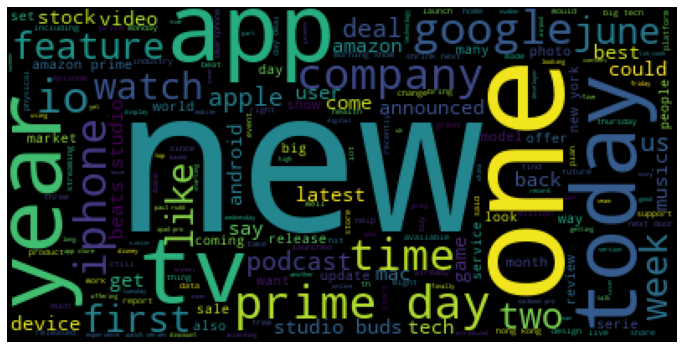

In [732]:
# Plot wordcount

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off')

### Functionizing Word Clouds

In [733]:
# Add company names to stopword list

stopwords_list.append('Apple')
stopwords_list.append('Facebook')
stopwords_list.append('Microsoft')
stopwords_list.append('Google')
stopwords_list.append('Netflix')
stopwords_list.append('Amazon')

In [734]:
# Text preprocessor

def preprocess_text(sentence):
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokenizer = RegexpTokenizer(pattern)
    tokens = tokenizer.tokenize(sentence)
    stopped_tokens= [w.lower() for w in tokens  if w.lower() not in stopwords_list]
    return stopped_tokens

In [735]:
#Functionize wordcloud maker

def create_wordcloud(df, sent, stop):

  wordcloud = WordCloud(collocations=True, stopwords=stop)
  df['tokens'] = df['cont_joined'].map(lambda x: preprocess_text(x))
  corpus = df[df['Sentiment']==sent]['cont_joined'].to_list()
  corpus = ",".join(corpus)
  wordcloud.generate(corpus)
  plt.figure(figsize = (12, 12), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis('off')

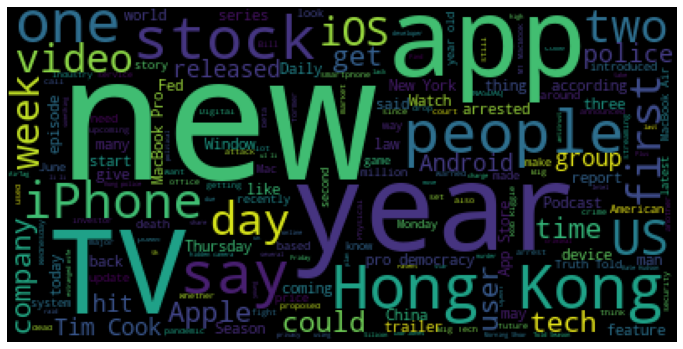

In [736]:
create_wordcloud(apple,-1,stopwords_list)

## TF-IDF Vectorizer

In [737]:
# Create X and y data

X = apple.iloc[:,8]
y= apple.iloc[:,-2]

In [738]:
# Perform train-test-split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,
                                                    random_state=42)

In [739]:
# Check distribution
# Add visual here

y_train.value_counts(normalize=True)

 1    0.525434
 0    0.317175
-1    0.157391
Name: Sentiment, dtype: float64

In [740]:
# Ensure shapes line up properly

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1671,)
(717,)
(1671,)
(717,)


In [741]:
# Create vectorizer object

from sklearn.feature_extraction.text import TfidfVectorizer
tokenizer = RegexpTokenizer(pattern)

vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize,
                             stop_words=stopwords_list)

In [742]:
# Fit transform train test, transform test data

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amazon', 'facebook', 'google', 'microsoft', 'netflix'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [743]:
# Ensure shapes match

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(1671, 10162)
(717, 10162)


In [744]:
# Bring in random forest

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced')

In [745]:
# Fit model

rf.fit(X_train_tfidf,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

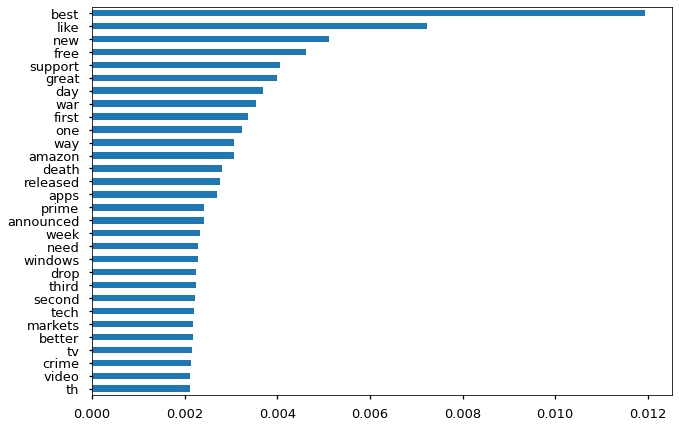

In [746]:
# Check feature importances
# Do this with pipeline

import seaborn as sns
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

with plt.style.context('seaborn-talk'):

    ## Get Feature Importance
    importance = pd.Series(rf.feature_importances_,
                           index=vectorizer.get_feature_names())

    ## Take the .tail 30 and plot kind='barh'
    importance.sort_values().tail(30).plot(kind='barh')

## Random Forest Model

In [747]:
# Dummy Classifier
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train_tfidf,y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [748]:
from sklearn.metrics import classification_report

def evaluate_model(fit_model, X_train, X_test, y_train, y_test, cmap='Blues', normalize='true'):
    """
    Returns results of a fit model
    Parameters: fit model, training and test data, can optionally adjust color palette and normalized matrix
    Returns: Classification report, ROC curve, AUC score, confusion matrix, and training vs test F1 results
    """
    
    y_hat_test = fit_model.predict(X_test)
    y_hat_train = fit_model.predict(X_train)
    print('********************CLASSIFICATION REPORT - TRAIN *************************') 
    print(classification_report(y_train, y_hat_train))
    print('********************CLASSIFICATION REPORT - TEST *************************') 
    print(classification_report(y_test, y_hat_test))
    print('*********************************************************************') 
    
    # fig, axes = plt.subplots(ncols=2, figsize=(10,4))
    # plot_roc_curve(fit_model, X_test, y_test, ax=axes[0])
    cm = cm = confusion_matrix(y_test, y_hat_test)
    sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    


********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       0.17      0.17      0.17       263
           0       0.33      0.35      0.34       530
           1       0.53      0.50      0.51       878

    accuracy                           0.40      1671
   macro avg       0.34      0.34      0.34      1671
weighted avg       0.41      0.40      0.40      1671

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.10      0.13      0.11        99
           0       0.29      0.31      0.30       235
           1       0.50      0.44      0.47       383

    accuracy                           0.35       717
   macro avg       0.30      0.29      0.29       717
weighted avg       0.38      0.35      0.36       717

*********************************************************************


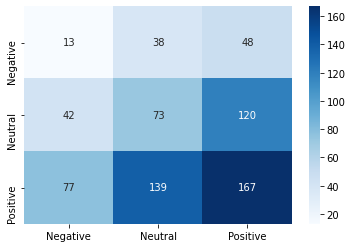

In [749]:
evaluate_model(dummy_clf, X_train_tfidf, X_test_tfidf, y_train, y_test)

Dummy classifier has an accuracy of 39%

In [750]:
from sklearn.metrics import accuracy_score

In [751]:
# accuracy_score()
y_pred = rf.predict(X_test_tfidf)


In [752]:
# Check accuracy score of Random Forest model

accuracy_score(y_test, y_pred)

0.6290097629009763

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       263
           0       1.00      1.00      1.00       530
           1       1.00      1.00      1.00       878

    accuracy                           1.00      1671
   macro avg       1.00      1.00      1.00      1671
weighted avg       1.00      1.00      1.00      1671

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.69      0.24      0.36        99
           0       0.53      0.43      0.47       235
           1       0.66      0.85      0.75       383

    accuracy                           0.63       717
   macro avg       0.63      0.51      0.53       717
weighted avg       0.62      0.63      0.60       717

*********************************************************************


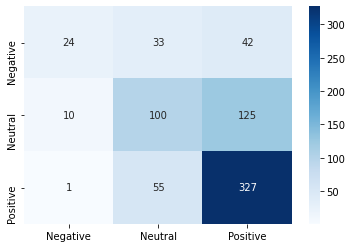

In [753]:
evaluate_model(rf, X_train_tfidf, X_test_tfidf, y_train, y_test)

Random Forest model has an accuracy of 62% compared with 39% from the Dummy Classifier. Significant increase compared to a random guess

## Logistic Regression

In [754]:
# Try using Vanilla Logistic Regression model

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
clf_lr = LogisticRegression(C=1e12, class_weight='balanced')

In [755]:
# Fit the model

clf_lr.fit(X_train_tfidf, y_train)

LogisticRegression(C=1000000000000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       263
           0       1.00      1.00      1.00       530
           1       1.00      1.00      1.00       878

    accuracy                           1.00      1671
   macro avg       1.00      1.00      1.00      1671
weighted avg       1.00      1.00      1.00      1671

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.48      0.36      0.41        99
           0       0.52      0.49      0.50       235
           1       0.69      0.77      0.73       383

    accuracy                           0.62       717
   macro avg       0.57      0.54      0.55       717
weighted avg       0.61      0.62      0.61       717

*********************************************************************


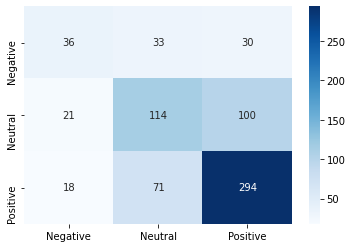

In [756]:
# Evaluate performance

evaluate_model(clf_lr, X_train_tfidf, X_test_tfidf, y_train, y_test)

Model performs slightly worse than Random Forest model and does not produce feature importance

## Building Pipeline

In [757]:
# Bring in Pipeline and CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

In [758]:
# Bring in TfidfTransformer
# Pipeline includes two text transformers

from sklearn.feature_extraction.text import TfidfTransformer
text_pipe = Pipeline(steps=[
    ('count_vectorizer',CountVectorizer(lowercase=True)),
    ('tf_transformer',TfidfTransformer(use_idf=True))
])

In [759]:
# Doesn't need to be a pipeline

from sklearn.feature_extraction.text import TfidfVectorizer

In [760]:
# Pipeline includes text and RF Classifier

full_pipe = Pipeline([('text_pipe',text_pipe),
                     ('clf',RandomForestClassifier(class_weight='balanced', n_jobs=-1))])

In [761]:
# Check parameters are availabe to modify

full_pipe.get_params()

{'clf': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                        warm_start=False),
 'clf__bootstrap': True,
 'clf__ccp_alpha': 0.0,
 'clf__class_weight': 'balanced',
 'clf__criterion': 'gini',
 'clf__max_depth': None,
 'clf__max_features': 'auto',
 'clf__max_leaf_nodes': None,
 'clf__max_samples': None,
 'clf__min_impurity_decrease': 0.0,
 'clf__min_impurity_split': None,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 2,
 'clf__min_weight_fraction_leaf': 0.0,
 'clf__n_estimators': 100,
 'clf__n_jobs': 

In [762]:
run_pipe=False
if run_pipe: 

  from sklearn.model_selection import GridSearchCV
  params = {'text_pipe__use_idf':[True],
          'text_pipe__smooth_idf':[True,False],
          'text_pipe__stop_words':[stopwords_list, 'english'],
          'text_pipe__ngram_range': [(1, 2), (1,1)], #make change to ngram
          'text_pipe__max_df':[1.0,0.99],
          'text_pipe__min_df':[0.01, 0.03],
          'text_pipe__norm':['l2','l1'],
          'clf__criterion':['gini','entropy'],
          'clf__max_depth':[None, 100, 200],
          'clf__min_samples_leaf': [1,5]
          }

  ## Make and fit grid
  grid4 = GridSearchCV(full_pipe,
                    params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
  grid4.fit(X_train,y_train)
  ## Display best params
  grid4.best_params_

In [763]:
# test =grid4.best_estimator_.named_steps['text_pipe']

In [764]:
import joblib
run_pipe=False
if run_pipe: 

  # from sklearn.model_selection import GridSearchCV
  params = {'text_pipe__TfidfVectorizer__use_idf':[True,False],
          'text_pipe__TfidfVectorizer__norm':['l2','l1'],
          'text_pipe__TfidfVectorizer__smooth_idf':[True,False],
          'text_pipe__TfidfVectorizer__stop_words':[stopwords_list,'english'],
            'text_pipe__TfidfVectorizer__ngram_range': [(1, 2)], #make change to ngram
            'text_pipe__TfidfVectorizer__max_df':[1.0,0.99],
            'text_pipe__TfidfVectorizer__min_df':[0.01, 0.03],
            'clf__criterion':['gini','entropy'],
            'clf__max_depth':[None, 5],
            'clf__min_samples_leaf': [1,5]
          }

  # Make and fit grid
  grid2 = GridSearchCV(full_pipe,
                     params, cv=3, scoring='recall_macro',n_jobs=-1,verbose=2)
  grid2.fit(X_train,y_train)
  # Display best params
  grid2.best_params_

  # Move model into model folder

  import joblib
  joblib.dump(grid2, '/content/drive/MyDrive/Colab Notebooks/Data/apple1_nlp_test.pkl')
else:
  apple_pipe = joblib.load('/content/drive/MyDrive/Colab Notebooks/Data/models/apple1_bp.pkl')
  apple_pipe

In [765]:
# Ensure we have access to the objects

apple_pipe.named_steps['clf']

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=200, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [766]:
# Ensure we have access to the objects

apple_pipe.named_steps['text_pipe']

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>,
                lowercase=True, max_df=1.0, max_features=None, min_df=0.01,
                ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

# Interpretation

## RFM Feature Interpetation

In [767]:
def create_vars(grid,X_train, y_train):
  
  # Establish variables
  clf = grid.named_steps['clf']
  vecto = grid.named_steps['text_pipe']
  X_train_tfidf = vecto.fit_transform(X_train)
  X_test_tfidf = vecto.transform(X_test)

  return clf, vecto, X_train_tfidf, X_test_tfidf

In [768]:
clf5, vect5, X_train_tfidf5, X_test_tfidf5 = create_vars(apple_pipe,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       0.98      1.00      0.99       263
           0       1.00      1.00      1.00       530
           1       1.00      1.00      1.00       878

    accuracy                           1.00      1671
   macro avg       0.99      1.00      1.00      1671
weighted avg       1.00      1.00      1.00      1671

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.33      0.26      0.29        99
           0       0.52      0.45      0.48       235
           1       0.68      0.77      0.72       383

    accuracy                           0.60       717
   macro avg       0.51      0.49      0.50       717
weighted avg       0.58      0.60      0.58       717

*********************************************************************


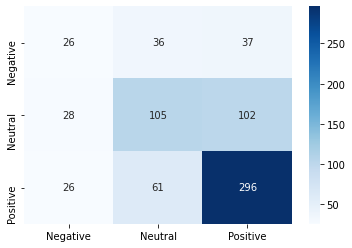

In [769]:
evaluate_model(clf5, X_train_tfidf5, X_test_tfidf5, y_train, y_test)

In [770]:
def create_feature_importance(clf, vect, company):
  importance = pd.Series(clf.feature_importances_,
                        index=vect.get_feature_names())
  if company in importance:
    importance.drop(company, inplace=True)
  else:
    pass
  

  # Take the .tail 30 and plot kind='barh'
  ax = importance.sort_values().tail(25).plot(kind='barh')
  return ax

# Prep Data for Feature importance


## APPLE DATA

In [771]:
# Automatically perform train/test/split

def train_test(filepath):

  # Load in Data from crisp folder
  df = pd.read_csv(filepath)

  # Create X and y data
  X = df.iloc[:,8]
  y= df.iloc[:,-1]

  # Train-test split
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,
                                                      random_state=42)
  return X_train, X_test, y_train, y_test

In [772]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

full_pipe = Pipeline([('text_pipe',text_pipe),
                     ('clf',RandomForestClassifier(class_weight='balanced', n_jobs=-1))])

In [773]:
# Make note at top of NB or what run_grid does
# Set to False as default
run_grid=False
import joblib, os
DATA_MODEL= f'{DATA_PATH}/models/'
os.makedirs(DATA_MODEL, exist_ok=True)

**IMPORTANT NOTE**: If running grid search, takes aprox ~10/15 mins to complete per search

In [774]:
app1 = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_apple1.csv'
X_train, X_test, y_train, y_test = train_test(app1)

In [775]:
if run_grid:

  params = {
          'text_pipe__use_idf':[True],
          'text_pipe__stop_words':[stopwords_list, 'english'],
          'text_pipe__ngram_range': [(1, 2), (1,1)], #make change to ngram
          'text_pipe__max_df':[1.0,0.99],
          'text_pipe__min_df':[0.01, 0.03],
          'text_pipe__norm':['l2','l1'],
          'clf__criterion':['gini','entropy'],
          'clf__max_depth':[None, 100, 200],
          'clf__min_samples_leaf': [1,5]
          }

  # Make and fit grid
  apple1 = GridSearchCV(full_pipe,
                    params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
  apple1.fit(X_train,y_train)

  # Save best estimator
  apple1_bp = apple1.best_estimator_
  
  joblib.dump(apple1_bp, f'{DATA_MODEL}apple1_bp.pkl')
else:
  apple1_bp=joblib.load(f'{DATA_MODEL}apple1_bp.pkl')
  print('Sucessfully loaded pickle file \n')
apple1_bp



Sucessfully loaded pickle file 



Pipeline(memory=None,
         steps=[('text_pipe',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8',
                                 input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>,
                                 lowercase=True, max_df=1....
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=200,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                     

In [776]:
apple1_clf, apple1_vect, X_train_apple1, X_test_apple1 = create_vars(apple1_bp,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       0.98      1.00      0.99       263
           0       1.00      1.00      1.00       530
           1       1.00      1.00      1.00       878

    accuracy                           1.00      1671
   macro avg       0.99      1.00      1.00      1671
weighted avg       1.00      1.00      1.00      1671

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.33      0.26      0.29        99
           0       0.52      0.45      0.48       235
           1       0.68      0.77      0.72       383

    accuracy                           0.60       717
   macro avg       0.51      0.49      0.50       717
weighted avg       0.58      0.60      0.58       717

*********************************************************************


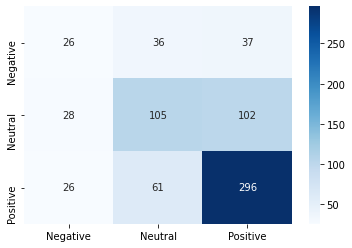

In [777]:
evaluate_model(apple1_clf, X_train_apple1, X_test_apple1, y_train, y_test)

60% accuracy, negative recall is the worst performer

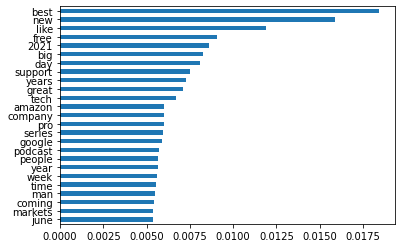

In [778]:
apple1_fi = create_feature_importance(apple1_clf, apple1_vect, 'apple')

Random Forest Feature Importance represents which features decreased the impurity of a decision tree the most. They can be thought of as the features which help the most in creating the nodes for the decision tree. 

In this instance 'best', 'new', and 'like' are the most important features for determing sentiment

Apple Week 2

In [779]:
app2 = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_apple2.csv'
apple2 = pd.read_csv(app2)

In [780]:
# app2 = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_apple2.csv'
# X_train, X_test, y_train, y_test = train_test(app2)

In [781]:
# apple2.head(3)

In [782]:
X = apple2.iloc[:,8]
y = apple2.iloc[:,-1]

In [783]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,
                                                    random_state=42)

In [784]:
## Produce gridsearch best estimator

if run_grid:
  # Run grid search and fit model
  apple2 = GridSearchCV(full_pipe,
                    params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
  apple2.fit(X_train,y_train)

  # Save best_estimator

  apple2_bp = apple2.best_estimator_
  joblib.dump(apple2_bp, '/content/drive/MyDrive/Colab Notebooks/Data/apple2_bp.pkl')

else:
  apple2_bp=joblib.load(f'{DATA_MODEL}apple2_bp.pkl')
  print('Sucessfully loaded pickle file \n')
apple2_bp

Sucessfully loaded pickle file 



Pipeline(memory=None,
         steps=[('text_pipe',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8',
                                 input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>,
                                 lowercase=True, max_df=0....
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=200,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                     

In [785]:
apple2_clf, apple2_vect, X_train_apple2, X_test_apple2 = create_vars(apple2_bp,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       242
           0       1.00      1.00      1.00       538
           1       1.00      1.00      1.00      1015

    accuracy                           1.00      1795
   macro avg       1.00      1.00      1.00      1795
weighted avg       1.00      1.00      1.00      1795

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.44      0.22      0.30        89
           0       0.49      0.40      0.44       232
           1       0.68      0.82      0.75       449

    accuracy                           0.62       770
   macro avg       0.54      0.48      0.50       770
weighted avg       0.60      0.62      0.60       770

*********************************************************************


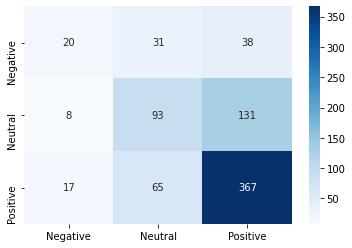

In [786]:
evaluate_model(apple2_clf, X_train_apple2, X_test_apple2, y_train, y_test)

62% accuracy, negative recall is the worst performer

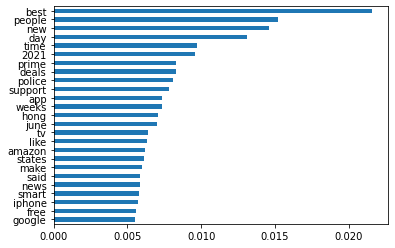

In [787]:
apple2_fi = create_feature_importance(apple2_clf, apple2_vect, 'apple')

In this instance 'best', 'people', and 'new' are the most important features for determing sentiment. There are some specific Apple events mixed in which had to do with the issues arriving in a different company in Hong Kong.

## FACEBOOK DATA

In [788]:
# Load in FB Data from crisp folder
fb1 = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_fb1.csv'
X_train, X_test, y_train, y_test = train_test(fb1)

In [789]:
## Produce gridsearch best estimator

if run_grid:

  # Run grid search and fit model
  fb1 = GridSearchCV(full_pipe,
                    params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
  fb1.fit(X_train,y_train)

  # Save best_estimator
  fb1_bp = fb1.best_estimator_
  joblib.dump(fb1_bp, '/content/drive/MyDrive/Colab Notebooks/Data/fb1_bp.pkl')
else:
  fb1_bp=joblib.load(f'{DATA_MODEL}fb1_bp.pkl')
  print('Sucessfully loaded pickle file \n')
fb1_bp

Sucessfully loaded pickle file 



Pipeline(memory=None,
         steps=[('text_pipe',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8',
                                 input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>,
                                 lowercase=True, max_df=0....
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='entropy', max_depth=200,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                  

In [790]:
fb1_clf, fb1_vect, X_train_fb1, X_test_fb1 = create_vars(fb1_bp,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       435
           0       1.00      1.00      1.00       577
           1       1.00      1.00      1.00       745

    accuracy                           1.00      1757
   macro avg       1.00      1.00      1.00      1757
weighted avg       1.00      1.00      1.00      1757

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.52      0.53      0.53       196
           0       0.50      0.46      0.48       224
           1       0.65      0.68      0.66       333

    accuracy                           0.58       753
   macro avg       0.56      0.56      0.56       753
weighted avg       0.57      0.58      0.57       753

*********************************************************************


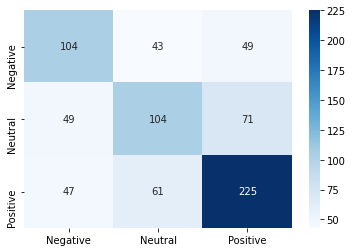

In [791]:
evaluate_model(fb1_clf, X_train_fb1, X_test_fb1, y_train, y_test)

58% accuracy, neutral recall is the worst performer

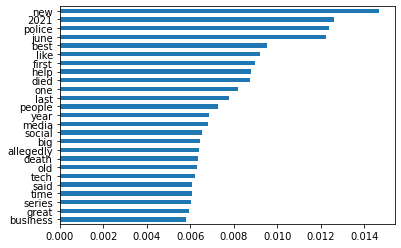

In [792]:
fb1_fi = create_feature_importance(fb1_clf, fb1_vect, 'facebook')

In this instance 'new', '2021', and 'police' are the most important features for determing sentiment. Facebook news headlines may be more politically charged as police is one of the main words. There are also words like social and big which may be an interesting bigram to explore (ie big tech)

Facebook Week 2 Data

In [793]:
fb2= 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_fb2.csv'
X_train, X_test, y_train, y_test = train_test(fb2)

In [794]:
## Produce gridsearch best estimator

if run_grid:

  # Run grid search and fit model
  fb2 = GridSearchCV(full_pipe,
                    params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
  fb2.fit(X_train,y_train)

  # Save best estimator
  fb2_bp = fb2.best_estimator_
  joblib.dump(fb2_bp, '/content/drive/MyDrive/Colab Notebooks/Data/fb2_bp.pkl')

else:
  fb2_bp=joblib.load(f'{DATA_MODEL}fb2_bp.pkl')
  print('Sucessfully loaded pickle file \n')
fb2_bp 

Sucessfully loaded pickle file 



Pipeline(memory=None,
         steps=[('text_pipe',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8',
                                 input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>,
                                 lowercase=True, max_df=1....
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='entropy', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                 

In [795]:
fb2_clf, fb2_vect, X_train_fb2, X_test_fb2 = create_vars(fb2_bp,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       418
           0       1.00      1.00      1.00       509
           1       1.00      1.00      1.00       840

    accuracy                           1.00      1767
   macro avg       1.00      1.00      1.00      1767
weighted avg       1.00      1.00      1.00      1767

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.68      0.47      0.56       195
           0       0.49      0.34      0.40       229
           1       0.57      0.79      0.66       334

    accuracy                           0.57       758
   macro avg       0.58      0.53      0.54       758
weighted avg       0.57      0.57      0.56       758

*********************************************************************


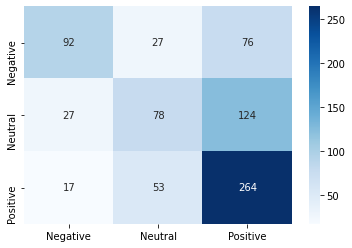

In [796]:
evaluate_model(fb2_clf, X_train_fb2, X_test_fb2, y_train, y_test)

57% accuracy, neutral recall is the worst performer

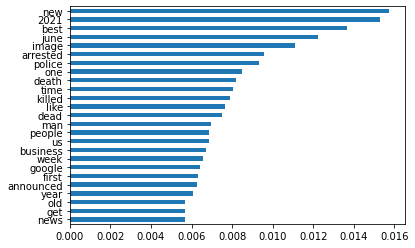

In [797]:
fb2_fi = create_feature_importance(fb2_clf, fb2_vect, 'facebook')

In this instance 'new', '2021', and 'best' are the most important features for determing sentiment. Again, Facebook is more politically charged. The downside of feature importance is you can't see which direction it is shifting the sentiment

## NETFLIX DATA

In [798]:
nflx1 = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_nflx1.csv'
X_train, X_test, y_train, y_test = train_test(nflx1)

In [799]:
## Produce gridsearch best estimator

if run_grid:

  # Run grid search and fit model
  nf1 = GridSearchCV(full_pipe,
                    params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
  nf1.fit(X_train,y_train)

  # Save the best estimator
  nf1_bp = nf1.best_estimator_
  joblib.dump(nf1_bp, '/content/drive/MyDrive/Colab Notebooks/Data/nf1_bp.pkl')

else:
  nf1_bp=joblib.load(f'{DATA_MODEL}nf1_bp.pkl')
  print('Sucessfully loaded pickle file \n')
nf1_bp  

Sucessfully loaded pickle file 



Pipeline(memory=None,
         steps=[('text_pipe',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8',
                                 input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>,
                                 lowercase=True, max_df=0....
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='entropy', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                 

In [800]:
nf1_clf, nf1_vect, X_train_nf1, X_test_nf1 = create_vars(nf1_bp,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       0.99      1.00      1.00       140
           0       1.00      0.99      1.00       194
           1       1.00      1.00      1.00       389

    accuracy                           1.00       723
   macro avg       1.00      1.00      1.00       723
weighted avg       1.00      1.00      1.00       723

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.58      0.25      0.35        57
           0       0.54      0.37      0.44        92
           1       0.62      0.85      0.72       162

    accuracy                           0.60       311
   macro avg       0.58      0.49      0.50       311
weighted avg       0.59      0.60      0.57       311

*********************************************************************


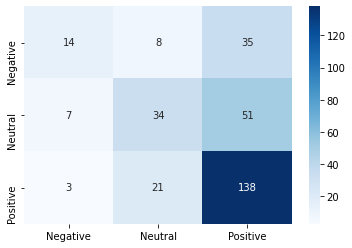

In [801]:
evaluate_model(nf1_clf, X_train_nf1, X_test_nf1, y_train, y_test)

60% accuracy, negative recall is the worst performer

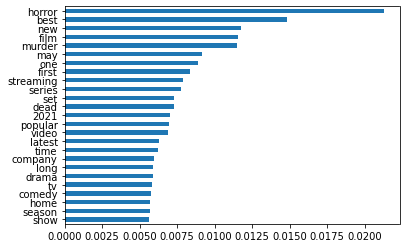

In [802]:
nf1_fi = create_feature_importance(nf1_clf, nf1_vect, 'netflix')

In this instance 'horrow', 'best', and 'new' are the most important features for determing sentiment. Netflix news headlines appear more related to Netflix content then company specific headlines, all they go hand-in-hand. Common words like 'series', 'comedy', are popping up.

Netflix Week 2

In [803]:
nflx2 = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_nflx2.csv'
X_train, X_test, y_train, y_test = train_test(nflx2)

In [804]:
## Produce gridsearch best estimator

if run_grid:

  # Run grid search and fit model
  nf2 = GridSearchCV(full_pipe,
                    params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
  nf2.fit(X_train,y_train)

  # Save the best estimator
  nf2_bp = nf2.best_estimator_
  joblib.dump(nf2_bp, '/content/drive/MyDrive/Colab Notebooks/Data/nf2_bp.pkl')

else:
  nf2_bp=joblib.load(f'{DATA_MODEL}nf2_bp.pkl')
  print('Sucessfully loaded pickle file \n')
nf2_bp  

Sucessfully loaded pickle file 



Pipeline(memory=None,
         steps=[('text_pipe',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8',
                                 input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>,
                                 lowercase=True, max_df=1....
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=200,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                     

In [805]:
nf2_clf, nf2_vect, X_train_nf2, X_test_nf2 = create_vars(nf2_bp,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       138
           0       1.00      1.00      1.00       293
           1       1.00      1.00      1.00       463

    accuracy                           1.00       894
   macro avg       1.00      1.00      1.00       894
weighted avg       1.00      1.00      1.00       894

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.38      0.15      0.21        68
           0       0.61      0.44      0.51       136
           1       0.57      0.82      0.67       180

    accuracy                           0.57       384
   macro avg       0.52      0.47      0.46       384
weighted avg       0.55      0.57      0.53       384

*********************************************************************


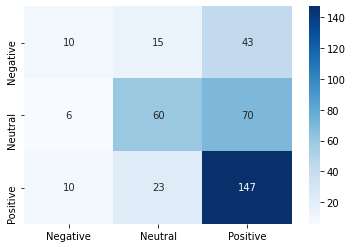

In [806]:
evaluate_model(nf2_clf, X_train_nf2, X_test_nf2, y_train, y_test)

57% accuracy, negative recall is the worst performer

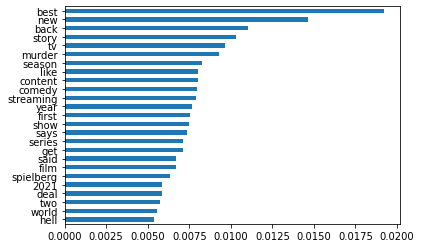

In [807]:
nf1_f2 = create_feature_importance(nf2_clf, nf2_vect, 'netflix')

In this instance 'horrow', 'best', and 'back' are the most important features for determing sentiment. Again, Netflix news headlines appear more related to Netflix content then company specific headlines

## AMAZON DATA

In [808]:
am1 = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_am1.csv'
X_train, X_test, y_train, y_test = train_test(am1)

In [809]:
## Produce gridsearch best estimator

if run_grid:

  # Run grid search and fit model
  am1 = GridSearchCV(full_pipe,
                    params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
  am1.fit(X_train,y_train)

  # Save the best estimator
  am1_bp = am1.best_estimator_
  joblib.dump(am1_bp, '/content/drive/MyDrive/Colab Notebooks/Data/am1_bp.pkl')

else:
  am1_bp=joblib.load(f'{DATA_MODEL}am1_bp.pkl')
  print('Sucessfully loaded pickle file \n')
am1_bp

Sucessfully loaded pickle file 



Pipeline(memory=None,
         steps=[('text_pipe',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8',
                                 input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>,
                                 lowercase=True, max_df=0....
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='entropy', max_depth=200,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                  

In [810]:
am1_clf, am1_vect, X_train_am1, X_test_am1 = create_vars(am1_bp,X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amazon', 'facebook', 'google', 'microsoft', 'netflix'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       0.97      1.00      0.98       202
           0       1.00      0.99      0.99       473
           1       1.00      1.00      1.00      1045

    accuracy                           1.00      1720
   macro avg       0.99      1.00      0.99      1720
weighted avg       1.00      1.00      1.00      1720

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.34      0.11      0.17        88
           0       0.46      0.34      0.39       187
           1       0.71      0.87      0.78       463

    accuracy                           0.65       738
   macro avg       0.51      0.44      0.45       738
weighted avg       0.60      0.65      0.61       738

*********************************************************************


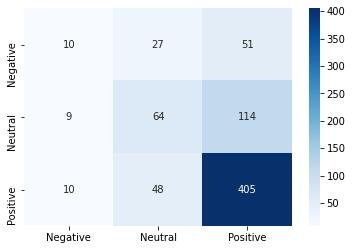

In [811]:
evaluate_model(am1_clf, X_train_am1, X_test_am1, y_train, y_test)

65% accuracy, negative recall is the worst performer. Very few true negative results

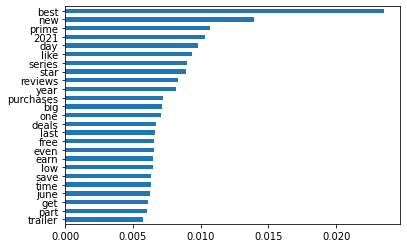

In [812]:
am1_fi = create_feature_importance(am1_clf, am1_vect, 'amazon')

In this instance 'best', 'new', and 'prime' are the most important features for determing sentiment. Amazon Prime Day was June 21st-22nd so there is a lot of mentions about Prime, most likely in a positive light. 

Amazon Week 2

In [813]:
am2 = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_am2.csv'
X_train, X_test, y_train, y_test = train_test(am2)

In [814]:
## Produce gridsearch best estimator

if run_grid:

  # Run grid search and fit model
  am2 = GridSearchCV(full_pipe,
                    params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
  am2.fit(X_train,y_train)

  # Save best estimator
  am2_bp = am2.best_estimator_
  joblib.dump(am2_bp, '/content/drive/MyDrive/Colab Notebooks/Data/am2_bp.pkl')

else:
  am2_bp=joblib.load(f'{DATA_MODEL}am2_bp.pkl')
  print('Sucessfully loaded pickle file \n')
am2_bp


Sucessfully loaded pickle file 



Pipeline(memory=None,
         steps=[('text_pipe',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8',
                                 input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>,
                                 lowercase=True, max_df=1....
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='entropy', max_depth=100,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                  

In [815]:
# from google.colab import drive
# drive.mount('/content/drive')

In [816]:
am2_clf, am2_vect, X_train_am2, X_test_am2 = create_vars(am2_bp,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       1.00      0.99      0.99       181
           0       0.99      1.00      0.99       426
           1       1.00      1.00      1.00      1216

    accuracy                           1.00      1823
   macro avg       1.00      1.00      1.00      1823
weighted avg       1.00      1.00      1.00      1823

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.45      0.21      0.28        68
           0       0.49      0.32      0.39       207
           1       0.73      0.89      0.80       507

    accuracy                           0.68       782
   macro avg       0.56      0.47      0.49       782
weighted avg       0.64      0.68      0.65       782

*********************************************************************


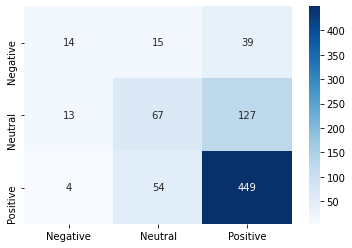

In [817]:
evaluate_model(am2_clf, X_train_am2, X_test_am2, y_train, y_test)

68% accuracy, negative recall is the worst performer

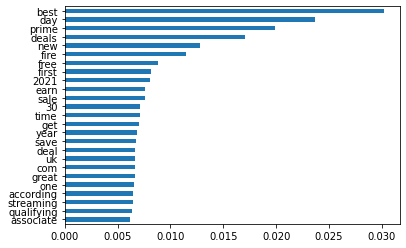

In [818]:
am2_fi = create_feature_importance(am2_clf, am2_vect, 'amazon')

In this instance 'best', 'day', and 'prime' are the most important features for determing sentiment. Amazon Prime Day was June 21st-22nd so there is a lot of mentions about Prime, most likely in a positive light. Fire, free, and streaming are other words associated with Amazon Prime memebership and Amazon Prime Day

## GOOGLE DATA

In [819]:
goog1 = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_goog1.csv'
X_train, X_test, y_train, y_test = train_test(goog1)

In [820]:
## Produce gridsearch best estimator

if run_grid:

  # Run grid search and fit model
  goog1 = GridSearchCV(full_pipe,
                    params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
  goog1.fit(X_train,y_train)

  # Save the best estimator
  goog1_bp = goog1.best_estimator_
  joblib.dump(goog1_bp, '/content/drive/MyDrive/Colab Notebooks/Data/goog1_bp.pkl')

else:
  goog1_bp=joblib.load(f'{DATA_MODEL}goog1_bp.pkl')
  print('Sucessfully loaded pickle file \n')
goog1_bp

Sucessfully loaded pickle file 



Pipeline(memory=None,
         steps=[('text_pipe',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8',
                                 input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>,
                                 lowercase=True, max_df=0....
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=100,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                     

In [821]:
goog1_clf, goog1_vect, X_train_goog1, X_test_goog1 = create_vars(goog1_bp,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       0.99      0.99      0.99       377
           0       0.99      1.00      1.00       725
           1       1.00      1.00      1.00       897

    accuracy                           1.00      1999
   macro avg       0.99      0.99      0.99      1999
weighted avg       1.00      1.00      1.00      1999

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.56      0.34      0.42       158
           0       0.51      0.60      0.55       281
           1       0.67      0.69      0.68       419

    accuracy                           0.59       858
   macro avg       0.58      0.54      0.55       858
weighted avg       0.60      0.59      0.59       858

*********************************************************************


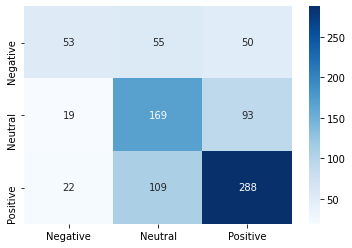

In [822]:
evaluate_model(goog1_clf, X_train_goog1, X_test_goog1, y_train, y_test)

59% accuracy, negative recall is the worst performer

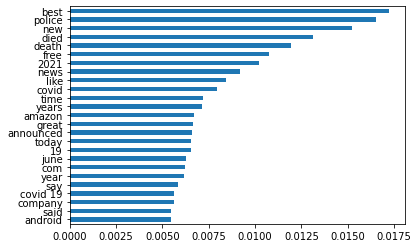

In [823]:
goog1_fi = create_feature_importance(goog1_clf, goog1_vect, 'google')

In this instance 'best', 'police', and 'new' are the most important features for determing sentiment. Android also appears which is specific to Google products

Google Week 2

In [824]:
goog2 = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_goog2.csv'
X_train, X_test, y_train, y_test = train_test("/content/drive/MyDrive/Colab Notebooks/Data/crisp_data/df_etl_goog2.csv")

In [825]:
## Produce gridsearch best estimator

if run_grid:

  # Run grid search and fit model
  goog2 = GridSearchCV(full_pipe,
                    params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
  goog2.fit(X_train,y_train)

  # Save the best estimator
  goog2_bp = goog2.best_estimator_
  joblib.dump(goog2_bp, '/content/drive/MyDrive/Colab Notebooks/Data/goog2_bp.pkl')

else:
  goog2_bp=joblib.load(f'{DATA_MODEL}goog2_bp.pkl')
  print('Sucessfully loaded pickle file \n')
goog2_bp

Sucessfully loaded pickle file 



Pipeline(memory=None,
         steps=[('text_pipe',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8',
                                 input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>,
                                 lowercase=True, max_df=1....
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                    

In [826]:
goog2_clf, goog2_vect, X_train_goog2, X_test_goog2 = create_vars(goog2_bp,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99       431
           0       1.00      1.00      1.00       664
           1       1.00      1.00      1.00       935

    accuracy                           1.00      2030
   macro avg       1.00      1.00      1.00      2030
weighted avg       1.00      1.00      1.00      2030

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.45      0.50      0.48       149
           0       0.48      0.44      0.46       304
           1       0.66      0.68      0.67       417

    accuracy                           0.57       870
   macro avg       0.53      0.54      0.54       870
weighted avg       0.56      0.57      0.56       870

*********************************************************************


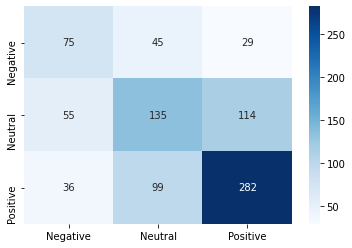

In [827]:
evaluate_model(goog2_clf, X_train_goog2, X_test_goog2, y_train, y_test)

57% accuracy, neutral recall is the worst performer

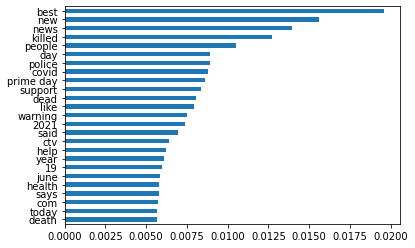

In [828]:
goog2_fi = create_feature_importance(goog2_clf, goog2_vect, 'google')

In this instance 'best', 'police', and 'news' are the most important features for determing sentiment. Interestingly there is a lot of words associated with violence such as killed, dead, warning, help, and death. 

## MICROSOFT DATA

In [829]:
msft1 ='https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_msft1.csv'
X_train, X_test, y_train, y_test = train_test(msft1)

In [830]:
## Produce gridsearch best estimator

if run_grid:

  # Run grid search and fit model
  ms1 = GridSearchCV(full_pipe,
                    params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
  ms1.fit(X_train,y_train)

  # Save best estimator
  ms1_bp = ms1.best_estimator_
  joblib.dump(ms1_bp, '/content/drive/MyDrive/Colab Notebooks/Data/ms1_bp.pkl')

else:
  ms1_bp=joblib.load(f'{DATA_MODEL}ms1_bp.pkl')
  print('Sucessfully loaded pickle file \n')
ms1_bp

Sucessfully loaded pickle file 



Pipeline(memory=None,
         steps=[('text_pipe',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8',
                                 input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>,
                                 lowercase=True, max_df=0....
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=100,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                     

In [831]:
ms1_clf, ms1_vect, X_train_ms1, X_test_ms1 = create_vars(ms1_bp,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       0.99      0.99      0.99       177
           0       1.00      1.00      1.00       403
           1       1.00      1.00      1.00       515

    accuracy                           1.00      1095
   macro avg       1.00      1.00      1.00      1095
weighted avg       1.00      1.00      1.00      1095

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.55      0.35      0.43        65
           0       0.58      0.56      0.57       167
           1       0.69      0.77      0.73       238

    accuracy                           0.64       470
   macro avg       0.61      0.56      0.58       470
weighted avg       0.63      0.64      0.63       470

*********************************************************************


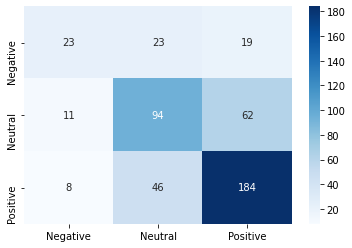

In [832]:
evaluate_model(ms1_clf, X_train_ms1, X_test_ms1, y_train, y_test)

64% accuracy, negative recall is the worst performer

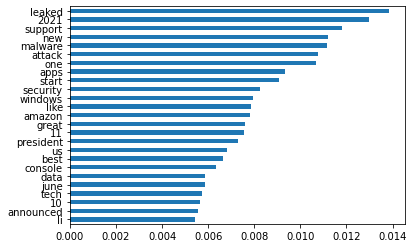

In [833]:
ms1_fi = create_feature_importance(ms1_clf, ms1_vect, 'microsoft')

In this instance 'leaked', '2021', and 'support' are the most important features for determing sentiment. Microsoft generally has terms that seem more specific to Microsoft products like windwos, console, 10 (windows 10) and more

Microsoft Week 2

In [834]:
msft2 ='https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_msft2.csv'
X_train, X_test, y_train, y_test = train_test(msft2)

In [835]:
## Produce gridsearch best estimator

if run_grid:

  # Run grid search and fit model
  ms2 = GridSearchCV(full_pipe,
                    params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
  ms2.fit(X_train,y_train)

  # Save best estimator
  ms2_bp = ms2.best_estimator_
  joblib.dump(ms2_bp, '/content/drive/MyDrive/Colab Notebooks/Data/ms2_bp.pkl')

else:
  ms2_bp=joblib.load(f'{DATA_MODEL}ms2_bp.pkl')
  print('Sucessfully loaded pickle file \n')
ms2_bp

Sucessfully loaded pickle file 



Pipeline(memory=None,
         steps=[('text_pipe',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8',
                                 input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>,
                                 lowercase=True, max_df=1....
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='entropy', max_depth=100,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                  

In [836]:
ms2_clf, ms2_vect, X_train_ms2, X_test_ms2 = create_vars(ms2_bp,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       0.98      1.00      0.99       131
           0       1.00      1.00      1.00       413
           1       1.00      1.00      1.00       706

    accuracy                           1.00      1250
   macro avg       0.99      1.00      0.99      1250
weighted avg       1.00      1.00      1.00      1250

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.67      0.26      0.38        68
           0       0.56      0.55      0.55       177
           1       0.70      0.81      0.75       292

    accuracy                           0.66       537
   macro avg       0.64      0.54      0.56       537
weighted avg       0.65      0.66      0.64       537

*********************************************************************


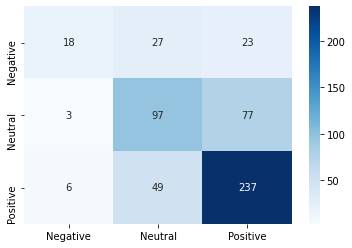

In [837]:
evaluate_model(ms2_clf, X_train_ms2, X_test_ms2, y_train, y_test)

66% accuracy, negative recall is the worst performer

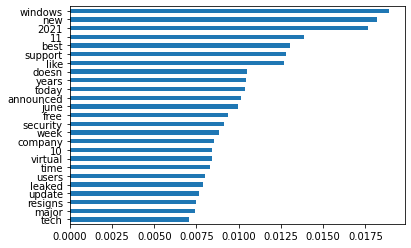

In [838]:
ms2_fi = create_feature_importance(ms2_clf, ms2_vect, 'microsoft')

In this instance 'windows', 'new', and '2021' are the most important features for determing sentiment. A new Windows version was released. It's interesting to say words sink down as time passes like 'leak.'


**OVERALL FEAUTRE IMPORTANCE CONCLUSIONS:** The drawback of feature importance is that it does not show the direction which the top features tilt the sentiment. However, it is still very useful in assessing which words within the corpus contain the most value for determining the sentiment of an article. Common accross all models was words like 'new', 'best', and then one other word usually related to the product or current event. For example, 'Windows', 'Series', 'Prime', or 'iPhone'. New and best based on their semantic meaning probably fell in line with positive sentiment. More specific product related words could land anywhere on the spectrum. In conclusion, it is useful to observe which words are making the most impact on sentiment to understand how the general public is percieving the company. 

**OVERALL MODEL EVALUATION CONCLUSIONS:** In regards to overall accuracy the model performed with between 55-67% accuracy. The dummy classifier had an accuracy of 40% and it was a multilabel classification problem ('Negative'/'Neutral'/'Positive'). This is an especially challenging task because the labels are based on unsupervised machine learning models so their accuracy is faily difficult to gauge. 'Negative' sentiment recall is where the model struggled the most. When optimizing for recall the accuracy suffered and I feel that accuracy is the most important metric to optimize for. In conclusion, I am satisfied with the model performance but would like to dive deeper into why the Random Forest model is overfitting.

# Appendix

## Additional Grid Searches

In [841]:
# Test based on msft2 data
# Testing different types of grid searches
run_atl_grid=False
if run_atl_grid:
  params2 = {
          'text_pipe__use_idf':[True],
          'text_pipe__stop_words':['english', None],
          'text_pipe__ngram_range': [(1,1)], #make change to ngram
          'text_pipe__max_df':[0.99],
          'text_pipe__min_df':[0.01],

          'text_pipe__norm':['l2','l1'],
          'clf__criterion':['gini','entropy'],
          'clf__max_depth':[None, 100, 200],
          'clf__min_samples_leaf': [1,2,3],
          'clf__min_samples_split': [1,5],
          'clf__max_leaf_nodes': [1,5,20],
      

          }

  ## Make and fit grid
  test_2 = GridSearchCV(full_pipe,
                    params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
  test_2.fit(X_train,y_train)




  test_2 = GridSearchCV(full_pipe,
                    params2, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
  test_2.fit(X_train,y_train)
else:
  pass

In [842]:
if run_atl_grid:
  test_bp = test_2.best_estimator_
else:
  pass

In [843]:
if run_atl_grid:
  test2_clf, test2_vect, X_train_test2, X_test_test2 = create_vars(test_bp,X_train, y_train)
else:
  pass

In [844]:
# Accuracy of 52%, far lower when incorporating for max features
# Accuracy of 53%

if run_atl_grid:
  evaluate_model(test2_clf, X_train_test2, X_test_test2, y_train, y_test)
else:
  pass